#### Recommendation System based on Association Rule, Multiple Correspondence Analysis, Co-clustering, SGD / WALS / Non-negative Matrix Factorizations for collaborative feature extractions; and Learning to Rank using combined neural network classification & regression (point-wise approach) and NDCG optimized Boosting Trees (pair-wise approach)

Continued with the fine food product reviews dataset from Amazon available from Kaggle: (https://www.kaggle.com/snap/amazon-fine-food-reviews/home), besides doing topic modelling and sentiment analysis, customer reviews and ratings on the products provided valuable informaion for building recommender system which helps marketing and sales operations as well as customer relationship management.

There is no fixed single way or architecture regarding to how the layout of a recommendation system should be, while evolvement of deep leaning and neural networks provided possibilities of alternatives for data scientists and engineers to test their uniquely designed hybrid pipelines. An usual technique for making data-driven recommendations is collaborative filtering, the components or underlying concepts of which could be divided mainly into item-based and user-based similarities or embeddings. Dimensionality reduction, clustering, and association rule mining methods act as key roles to extract implicit relationships between items and users of close characteristics like product specifications / categories or consumption behaviours.

<b>Data Preparations:</b> 

First it would be easier to filter active users who had been making purchases for more than a minimum number of times in order to study their preferences. Focusing on the latest 3-year data which accounts for around 80% of the total data rows, the reduced dataset consisted of 462,423 reviews tied with product IDs and user IDs. Defining the user base as including those writing 15 reviews or more, and grouping by the tokenized texts we could eventually get a table with 34,183 rows in which each row would be perceptually equivalent to one purchase or transaction made by one customer. One hot encoded vectors for products and users were obtained as document-product matrix and document-user matrix. Therefore, an user-product matrix, which was the key element for collaborative filtering, could be produced through matrix multiplication of the two matrices.

<b>Training & Testing set:</b>

The objective of the task was to enumerate the list of (user, product) pairs, learn the similarities and associations between users and productions through different supervised and unsupervised methods, and estimate its probability of existence in the testing set. Defining a testing set for the recommendation system might be a bit tricky, in order to simulate the purchasing acts in reality, there are in general two ways for validating the performance. One of the two is to reserve for each user the few final transactions as testing data, and evaluate by the percentages of precision or recall between them and the top products predicted from the model. Its advantage was guaranteeing sufficient points for testing the recommendation system. This approach assumes the context that each user would be making further purchases, but it might not be necessarily true in reality. Meanwhile as the timelines for each user's history were different, the effects of temporal features (if any) like promotions of products in some periods might not be well reflected. For a more realistical perspective, we could consider retrieving the reviews released within, for instance, the last half-year among the three-year periods as testing set. However, evaluations could only be made for those eventually making purchases in the testing period.

<b>Feature Extraction & Engineering:</b>
<ul><li>Collaborating Filtering on user-item based techniques: 
  <ul>
  <li>Association Rule on the customer-product matrix</li>
  <li>Multiple Correspondence Analysis on the customer-product matrix</li> 
  <li>Co-Clustering on customer-product matrices (binary / ratings)</li>
  <li>Latent factors for customer embeddings and product embeddings from:
      <ul><li>Stochastic Gradient Descent (SGD) matrix factorization</li>
          <li>Weighted Alternating Least Square (WALS) matrix factorization</li>
          <li>Non-negative matrix factorization (NMF)</li></ul></li></ul></li>
     <li>Review content based techniques:  
          <ul><li>Doc2Vec embeddings on tokenized review texts</li>
              <li>create aggregated embeddings (mean, max, min) per customer and per product</li></ul></li></ul>

<b>Model Building:</b>
<ul>
  <li>Learning to Rank by Neural Network Classifier & Regressor</li>
  <li>NDCG-based Boosting algorithms</li></ul>

In [0]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from scipy import sparse

The Natural Language Toolkit (nltk) package in Python was used for the main tokenization steps and redundant special character and stop-word removals which standardized the tokenized texts and avoided duplicates during groupby operations. The reviews served as content relevant features for getting word embeddings. The function <i><b>get_matrices()</b></i> transformed the raw dataframe and exgtracted the matrices used in collaborative filtering based feature engineering. 

I did some examinations on how long the period from which the data could be used as testing purpose, based on the percentages of co-existing users and products in the training set and testing set (since we would not predicting on the unseen new products and users as we had no evidence for estimating their similarities in the raw data). The higher this percentage the more favourable split would be. Meanwhile, comparatively fewer new products in the testing basket would be more desirable, though given the fast-moving consuming characteristics of food industry, the new products accounted for a significant proportion for each season. Lastly, I chose the latest 6 months compromising these two figures against other options of 3 months or 9 months.

Also, an issue that might be common in the wholesale industry, was that the product IDs were finely encoded in long-length strings and some product IDs appeared only a few times or with another fixed set of products concurrently. For association rule mining, this would generate only a small set of rules because most rules had confidence equal to 1.0 for no uncertainty. Predicting based on large bucket of items with high sparsity would also make the recommendation task more challenging, because the occurrences of some product IDs in the training set was not sufficient to generate significant relationships. While the prefix (first 5 digits of the product ID) could indicate the product type or category, we could use it for association rule mining or the first-stage filtering in making recomendations.

In [0]:
## read dataset
reviews = pd.read_csv('Reviews.csv')
## covert timestamp to datetime
reviews['Time'] = pd.to_datetime(reviews['Time'], unit='s')

## normalizing by lowercasing, removing special characters, tokenizing, and removing stopwords
from nltk import word_tokenize
from nltk import corpus
import re
## define stopword list
stop_words = corpus.stopwords.words('english')
## cleaning noises in texts
def normalize_doc(doc):
    # lower-case
    doc = doc.lower()
    # substitute special characters, digits & punctuations
    doc = re.sub('<br/>', ' ', doc)
    doc = re.sub('<br />', ' ', doc)
    doc = re.sub("'s|'m|'re|'ve|'ll|'d|n't", ' ', doc)
    doc = re.sub(r'"', ' ', doc)
    doc = re.sub(r'[^a-zA-Z\s]\W+|\d+|[!?@#%^&*\[\]\\(){}<>]|[.]|[/]|[$]|[-;:,`~=_+]', ' ', doc)
    # remove leading and trailing spaces
    doc = doc.strip()
    # tokenize
    tokens = word_tokenize(doc)
    # discard stopwords
    filtered_tokens = [x for x in tokens if x not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

## tokenization
text = reviews['Text']
summary = reviews['Summary']
token_list_text = []
token_list_text = [normalize_doc(x) for x in text]
token_list_summary = []
token_list_summary = [normalize_doc(str(x)) for x in summary]
## combine tokens from summary and review texts
token_list = []
token_list = [token_list_summary[x] + " " + token_list_text[x] for x in range(len(token_list_text))]

In [0]:
## read into dataframe
reviews['tokenized'] = pd.Series(token_list)

## extract last 3 years
reviews_reduced = reviews.groupby(['tokenized', 'ProductId', 'UserId']).agg(
                                  {'ProfileName': 'first',
                                   'HelpfulnessNumerator': ['max'],
                                   'HelpfulnessDenominator': ['max'],
                                   'Score': ['max'], 'Time': ['max'],
                                   'Summary': 'first', 'Text': 'first'})
reviews_reduced = reviews_reduced.reset_index(level=['tokenized', 'ProductId', 'UserId'])
reviews_reduced.columns = ['tokenized', 'ProductId', 'UserId', 'ProfileName', 'HelpfulVote', 
                           'AllVote', 'Score', 'Time', 'Summary', 'Text']
## extract last 3 years
reviews_reduced = reviews_reduced[reviews_reduced['Time']>=pd.Timestamp(2009,10,1)]

In [0]:
## aggregations by users making at least 15 reviews during the last 3 years
count_user = reviews_reduced.groupby(['UserId']).agg({'tokenized':pd.Series.nunique})
count_user = count_user.reset_index(level=['UserId'])
count_user.columns = ['UserId', 'Count_reviews']

## map to column in reviews
reviews_reduced = reviews_reduced.merge(count_user, left_on='UserId', right_on='UserId')

## extract only users with at least 15 reviews
trunc_df = reviews_reduced[reviews_reduced['Count_reviews']>=15]
trunc_df = trunc_df.reset_index(drop=True)

In [0]:
## load data
trunc_df = pd.read_csv(F'/content/drive/My Drive/Colab Notebooks/NLP/Recommendation System_fine food products.csv')
## sort data
trunc_df = trunc_df.sort_values(by=['tokenized'])
trunc_df = trunc_df.reset_index(drop=True)
trunc_df = trunc_df.iloc[:,1:]
trunc_df['Time'] = pd.to_datetime(trunc_df['Time'])

In [0]:
## possible categorized product IDs by first 5-digits; create additional column
trunc_df['ProductId_cat'] = trunc_df['ProductId'].apply(lambda x: str(x)[0:5])

In [0]:
trunc_df.iloc[0:20,:]

,tokenized,ProductId,UserId,ProfileName,HelpfulVote,AllVote,Score,Time,Summary,Text,Count_reviews,ProductId_cat
0,absolutely love plain ginger flavor gold kili...,B0041NYV8E,A16AXQ11SZA8SQ,"MamaBear007 ""MamaBear007""",0,1,2,2012-03-14,This just doesn't do it for me...,I absolutely love the plain ginger flavor if G...,30,B0041
1,agree recent reviews far taste bought lightni...,B000VK8AVK,A24ZV048V7J0MT,"Murphy ""Goldenmom""",0,0,3,2012-02-06,So So,"I have to agree with the recent reviews, these...",40,B000V
2,agree recent reviews far taste bought lightni...,B001RVFERK,A24ZV048V7J0MT,"Murphy ""Goldenmom""",0,0,3,2012-02-06,So So,"I have to agree with the recent reviews, these...",40,B001R
3,agree recent reviews far taste bought lightni...,B0026KNQSA,A24ZV048V7J0MT,"Murphy ""Goldenmom""",0,0,3,2012-02-06,So So,"I have to agree with the recent reviews, these...",40,B0026
4,agree recent reviews far taste bought lightni...,B0026KPDG8,A24ZV048V7J0MT,"Murphy ""Goldenmom""",0,0,3,2012-02-06,So So,"I have to agree with the recent reviews, these...",40,B0026
5,agree recent reviews far taste bought lightni...,B006HYLW32,A24ZV048V7J0MT,"Murphy ""Goldenmom""",0,0,3,2012-02-06,So So,"I have to agree with the recent reviews, these...",40,B006H
6,agree recent reviews far taste bought lightni...,B007M832YY,A24ZV048V7J0MT,"Murphy ""Goldenmom""",0,0,3,2012-02-06,So So,"I have to agree with the recent reviews, these...",40,B007M
7,agree recent reviews far taste bought lightni...,B007M83302,A24ZV048V7J0MT,"Murphy ""Goldenmom""",0,0,3,2012-02-06,So So,"I have to agree with the recent reviews, these...",40,B007M
8,agree recent reviews far taste bought lightni...,B0013NUGDE,A24ZV048V7J0MT,"Murphy ""Goldenmom""",0,0,3,2012-02-06,So So,"I have to agree with the recent reviews, these...",40,B0013
9,agree recent reviews far taste bought lightni...,B001RVFEP2,A24ZV048V7J0MT,"Murphy ""Goldenmom""",0,0,3,2012-02-06,So So,"I have to agree with the recent reviews, these...",40,B001R


In [0]:
trunc_df_train = trunc_df[trunc_df['Time']<pd.Timestamp(2012,4,1)]
trunc_df_train = trunc_df_train.reset_index(drop=True)
trunc_df_test = trunc_df[trunc_df['Time']>=pd.Timestamp(2012,4,1)]
trunc_df_test = trunc_df_test.reset_index(drop=True)

In [0]:
print(trunc_df.shape)
print(trunc_df_train.shape)
print(trunc_df_test.shape)

(34183, 12)
(23413, 12)
(10770, 12)


In [0]:
## in Compressed Sparse Row matrix format
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder, LabelEncoder

def generate_matrices(df, prod_level):
  lab_bin = LabelBinarizer(sparse_output=True)
  doc_product = lab_bin.fit_transform(df[[prod_level]])
  doc_user = lab_bin.fit_transform(df[['UserId']])
  doc_encoder = lab_bin.fit_transform(df[['tokenized']])

  ## extracting unique product IDs
  ## since the columns will be stored in alphabetic order in the LabelBinarizer, 
  ##  create a list to store sorted Product IDs
  prod_names = pd.DataFrame(df[prod_level].unique())
  prod_names.columns = [prod_level]
  prod_names = prod_names.sort_values(by=prod_level, ascending=True)
  prod_names = prod_names.reset_index(drop=True)

  ## extracting unique user IDs
  ## create a list to store sorted user IDs
  user_names = pd.DataFrame(df['UserId'].unique())
  user_names.columns = ['UserId']
  user_names = user_names.sort_values(by='UserId', ascending=True)
  user_names = user_names.reset_index(drop=True)

  ## A) create document-product matrix (binary & ratings)
  ## B) create document-user matrix (binary)
  doc_product_matrix = doc_encoder.T.dot(doc_product)
  doc_user_matrix = doc_encoder.T.dot(doc_user)

  ## generate counts of duplicated document & user given multiple products purchased, 
  ##  and divide the values in document-user matrix by the counts setting them to 1 and 0
  count_user = df.groupby(['tokenized', 'UserId']).agg({prod_level:pd.Series.nunique})
  count_user = count_user.reset_index(level=['tokenized', 'UserId'])
  count_user.columns = ['tokenized', 'UserId', 'Count_reviews_truncated']
  count_user = count_user.sort_values(by=['tokenized'])
  ## re-map to column in truncated dataframe
  df = df.merge(count_user, left_on=['tokenized', 'UserId'], right_on=['tokenized', 'UserId'])

  ## create diagonalized matrix for count_user
  diag_count_user = sparse.csr_matrix(np.diag(1 / count_user.iloc[:,-1]))

  ## get 0 or 1 binary document-user matrix
  doc_user_matrix = doc_user_matrix.T.dot(diag_count_user)
  doc_user_matrix = doc_user_matrix.T

  ## read the 5-point scale ratings
  rate_agg = df.groupby(['UserId', prod_level]).agg({'Score': ['mean']})
  rate_agg = rate_agg.reset_index()
  rate_agg.columns = ['UserId', prod_level, 'mean_score']
  rate_agg = rate_agg.sort_values(by=['UserId', prod_level])

  ## transaction-based product ratings
  doc_product_rating_matrix = df.groupby(['tokenized', prod_level]).agg({'Score': ['mean']})
  doc_product_rating_matrix = doc_product_rating_matrix.reset_index()
  doc_product_rating_matrix.columns = ['tokenized', prod_level, 'mean_score']
  doc_product_rating_matrix = doc_product_rating_matrix.pivot(index='tokenized', columns=prod_level, values='mean_score')
  doc_product_rating_matrix = doc_product_rating_matrix.fillna(0)

  ## C) create user-product matrix (binary & counts)
  ## D) create user-product ratings
  user_product_count_matrix = doc_user_matrix.T.dot(doc_product_matrix)

  user_matrix = lab_bin.fit_transform(rate_agg[['UserId']])
  product_matrix = lab_bin.fit_transform(rate_agg[[prod_level]])
  user_product_matrix = user_matrix.T.dot(product_matrix)

  user_product_rating_matrix = rate_agg.pivot(index='UserId', columns=prod_level, values='mean_score')
  user_product_rating_matrix = user_product_rating_matrix.fillna(0)

  return doc_product_matrix, doc_product_rating_matrix, doc_user_matrix, \
         user_product_count_matrix, user_product_matrix, user_product_rating_matrix, \
         prod_names, user_names, rate_agg

In [0]:
doc_product_matrix, doc_product_rating_matrix, doc_user_matrix, user_product_count_matrix, \
user_product_matrix, user_product_rating_matrix, prod_names, user_names, rate_agg \
= generate_matrices(trunc_df, "ProductId")

doc_product_matrix_train, doc_product_rating_matrix_train, doc_user_matrix_train, \
user_product_count_matrix_train, user_product_matrix_train, user_product_rating_matrix_train, \
prod_names_train, user_names_train, rate_agg_train \
= generate_matrices(trunc_df_train, "ProductId")

doc_product_matrix_test, doc_product_rating_matrix_test, doc_user_matrix_test, \
user_product_count_matrix_test, user_product_matrix_test, user_product_rating_matrix_test, \
prod_names_test, user_names_test, rate_agg_test \
= generate_matrices(trunc_df_test, "ProductId")

In [0]:
doc_category_matrix, doc_category_rating_matrix, doc_user_matrix, user_category_count_matrix, \
user_category_matrix, user_category_rating_matrix, category_names, user_names, rate_agg_c \
= generate_matrices(trunc_df, "ProductId_cat")

doc_category_matrix_train, doc_category_rating_matrix_train, doc_user_matrix_train, \
user_category_count_matrix_train, user_category_matrix_train, user_category_rating_matrix_train, \
category_names_train, user_names_train, rate_agg_c_train \
= generate_matrices(trunc_df_train, "ProductId_cat")

doc_category_matrix_test, doc_category_rating_matrix_test, doc_user_matrix_test, \
user_category_count_matrix_test, user_category_matrix_test, user_category_rating_matrix_test, \
category_names_test, user_names_test, rate_agg_c_test \
= generate_matrices(trunc_df_test, "ProductId_cat")

In [0]:
## last 6 months
print("Total product counts: " + str(len(prod_names)))
print("Product counts in training set: " + str(len(prod_names_train)))
print("Product counts in testing set: " + str(len(prod_names_test)))
print("New product counts in testing set: " + str(len(prod_names) - len(prod_names_train)))
print("Co-existing product counts in training & testing sets: " + str(len(prod_names_test) - (len(prod_names) - len(prod_names_train))))
print("New product %: " + "%.4f" % ((len(prod_names) - len(prod_names_train)) / len(prod_names_test)))
print("Co-existing product %: " + "%.4f" % ((len(prod_names_test) - (len(prod_names) - len(prod_names_train))) / len(prod_names_train)))
print("\n")
print("Total category counts: " + str(len(category_names)))
print("category counts in training set: " + str(len(category_names_train)))
print("category counts in testing set: " + str(len(category_names_test)))
print("New category counts in testing set: " + str(len(category_names) - len(category_names_train)))
print("Co-existing category counts in training & testing sets: " + str(len(category_names_test) - (len(category_names) - len(category_names_train))))
print("New category %: " + "%.4f" % ((len(category_names) - len(category_names_train)) / len(category_names_test)))
print("Co-existing category %: " + "%.4f" % ((len(category_names_test) - (len(category_names) - len(category_names_train))) / len(category_names_train)))
print("\n")
print("Total user counts: " + str(len(user_names)))
print("User counts in training set: " + str(len(user_names_train)))
print("User counts in testing set: " + str(len(user_names_test)))
print("New user counts in testing set: " + str(len(user_names) - len(user_names_train)))
print("Co-existing user counts in training & testing sets: " + str(len(user_names_test) - (len(user_names) - len(user_names_train))))
print("New user %: " + "%.4f" % ((len(user_names) - len(user_names_train)) / len(user_names_test)))
print("Co-existing user %: " + "%.4f" % ((len(user_names_test) - (len(user_names) - len(user_names_train))) / len(user_names_train)))

Total product counts: 14635
Product counts in training set: 11078
Product counts in testing set: 5374
New product counts in testing set: 3557
Co-existing product counts in training & testing sets: 1817
New product %: 0.6619
Co-existing product %: 0.1640


Total category counts: 346
category counts in training set: 320
category counts in testing set: 339
New category counts in testing set: 26
Co-existing category counts in training & testing sets: 313
New category %: 0.0767
Co-existing category %: 0.9781


Total user counts: 932
User counts in training set: 906
User counts in testing set: 854
New user counts in testing set: 26
Co-existing user counts in training & testing sets: 828
New user %: 0.0304
Co-existing user %: 0.9139


In [0]:
print(doc_product_matrix_train.shape)
print(doc_category_matrix_train.shape)
print(doc_user_matrix_train.shape)
print(user_product_matrix_train.shape)
print(user_category_matrix_train.shape)

(17037, 11078)
(17037, 320)
(17037, 906)
(906, 11078)
(906, 320)


To test the recommendation system, we inferred predictions on the rating scores for all enumerated pairs of users and products in the training set, and extracted the top items for recommendations by ranking all the combinations in descending orders. Based on collaborative filtering algorithms, I intended to get user-based and item-based embeddings, mapped back to the testing set when inferring the ratings.

In the actual testing set, we eliminated new users and products that did not appear in the training set, and also the repeated user-product pairs because intuitively we need not recommend items that a specific user had already bought. It would be another story for estimating the likelihoods on whether the customer will be making re-ordering.

As there were over 10 million possible combinations of user-product pairs, a better idea would be predicting on the user-product-category pairs as the first-stage screening, and thereafter selecting products pertaining to those categories from the huge-sized basket to save processing capacity. To do this, I separately produced two sets of combinations for later processing and model fitting.

General flow of the tentative recommender:<br>
<img src="pic/recommender system flow.PNG"/>

In [0]:
list_u = trunc_df_train['UserId'].unique().tolist()
list_p = trunc_df_train['ProductId'].unique().tolist()
list_c = trunc_df_train['ProductId_cat'].unique().tolist()

In [0]:
user_item_pairs = trunc_df_train[['UserId', 'ProductId']]
user_item_pairs['search_key'] = user_item_pairs['UserId'] + user_item_pairs['ProductId']
user_item_pairs['flag_purchased'] = 1

user_cat_pairs = trunc_df_train[['UserId', 'ProductId_cat']]
user_cat_pairs['search_key'] = user_cat_pairs['UserId'] + user_cat_pairs['ProductId_cat']
user_cat_pairs['flag_purchased'] = 1

In [0]:
## enumerate all possible combinations of user-item pairs in training set
combinations_p = [(a, b) for a in list_u for b in list_p]
combinations_p = pd.DataFrame(combinations_p)
combinations_p.columns = ['UserId', 'ProductId']
combinations_p['search_key'] = combinations_p['UserId'] + combinations_p['ProductId']

combinations_c = [(a, b) for a in list_u for b in list_c]
combinations_c = pd.DataFrame(combinations_c)
combinations_c.columns = ['UserId', 'ProductId_cat']
combinations_c['search_key'] = combinations_c['UserId'] + combinations_c['ProductId_cat']

In [0]:
## make the list of pairwise user-item combinations as the basket for making predictions
combinations_p = combinations_p.merge(user_item_pairs[['search_key', 'flag_purchased']], 
                                      how='left', on=['search_key'])
combinations_p = combinations_p[combinations_p['flag_purchased']!=1]
combinations_c = combinations_c.merge(user_cat_pairs[['search_key', 'flag_purchased']], 
                                      how='left', on=['search_key'])
combinations_c = combinations_c[combinations_c['flag_purchased']!=1]

In [0]:
## eliminate unseen new items in testing set because we have no other feature / product information available to determine similarities before actual purchase
## eliminate repeated user-item pairs in testing set because intuitively we need not recommend items that a specific user had already chosen to buy

ind_cat = []
ind_prod = []
ind_user = []
ind_repeated_pairs, ind_repeated_pairs_cat = [], []
for p in range(trunc_df_test.shape[0]):
    ind_prod.append(1 if trunc_df_test['ProductId'][p] in trunc_df_train['ProductId'].to_list() else 0)
    ind_user.append(1 if trunc_df_test['UserId'][p] in trunc_df_train['UserId'].to_list() else 0)
    ind_cat.append(1 if trunc_df_test['ProductId_cat'][p] in trunc_df_train['ProductId_cat'].to_list() else 0)
    ind_repeated_pairs.append(1 if ''.join(trunc_df_test[['UserId', 'ProductId']].iloc[p]) in user_item_pairs['search_key'].tolist() else 0)
    ind_repeated_pairs_cat.append(1 if ''.join(trunc_df_test[['UserId', 'ProductId_cat']].iloc[p]) in user_cat_pairs['search_key'].tolist() else 0)

trunc_df_test['flag_category'] = pd.Series(ind_cat)
trunc_df_test['flag_product'] = pd.Series(ind_prod)
trunc_df_test['flag_user'] = pd.Series(ind_user)
trunc_df_test['repeated'] = pd.Series(ind_repeated_pairs)
trunc_df_test['repeated_cat'] = pd.Series(ind_repeated_pairs_cat)

In [0]:
trunc_df_test_prod = trunc_df_test[(trunc_df_test['flag_product']==1) & (trunc_df_test['flag_user']==1) & (trunc_df_test['repeated']==0)].reset_index(drop=True)
trunc_df_test_cat = trunc_df_test[(trunc_df_test['flag_category']==1) & (trunc_df_test['flag_user']==1) & (trunc_df_test['repeated_cat']==0)].reset_index(drop=True)
trunc_df_test_prod = trunc_df_test_prod.sort_values(by=['tokenized'])
trunc_df_test_cat = trunc_df_test_cat.sort_values(by=['tokenized'])

In [0]:
## reproduce the test datasets
_, _, _, _, _, _, prod_names_test, user_names_test_p, rate_agg_test \
= generate_matrices(trunc_df_test_prod, "ProductId")

_, _, _, _, _, _, category_names_test, user_names_test_c, rate_agg_c_test \
= generate_matrices(trunc_df_test_cat, "ProductId_cat")

In [0]:
print(doc_product_matrix_test.shape)
print(user_product_matrix_test.shape)
print(doc_category_matrix_test.shape)
print(user_category_matrix_test.shape)

(7893, 5374)
(854, 5374)
(7893, 339)
(854, 339)


<b>Association Rule:</b>

Analyzing on the transaction-item records, market researchers commonly applied association rule mining methods to get the patterns of frequently co-occurring item setsin the basket. Ariori and FP-Growth algorithms are the two major classes, while the later one would be more efficiently implemented as it executes a tree-based structure employing depth-first search against Apriori which iterates on list objects doing breadth-first search with larger capacity required.

There are 5 metrics shown in the output of association rules in the "mlxtend" library: 
<ul><li>Support: <br>number of occurrences containing the quoted item sets in the entire transaction basket</li>
     <li>Confidence: <br>ratio of number of occurrences containing both antecedent item sets and consequent item sets to number of occurrences containing the antecedent item sets,
            i.e. <i>supp(A and B) / supp(A)</i></li>
     <li>Lift: <br>ratio between observed supports of A and B against the expected probabilities assuming A and B are independent, i.e. <i>supp(A and B) / (supp(A) x supp(B))</i></li>
     <li>Conviction: conceptually the probability of consequent item sets being not occurred given the confidence of no co-occurrence or no association, 
            i.e. <i>(1 - supp(A and B)) / (1 - conf(A => B))</i></li>
      <li>Leverage: difference between the observed supports of A and B and the independent probability of A and B co-occurrence, i.e. supp(A and B) - supp(A) x supp(B)</ul>
     
Setting thresholds on supports and confidences could truncate the size of resulting association rule sets, retaining only major significant rules to inspect. As said, product IDs were too precisely represented that most appeared a few times with another fixed set of products, it returned only 249 rule sets with confidence less than 1.0, while using the product category we could get a more informative set with over 65,000 rows for analyses and feature extractions. One review being treated as one transaction led to rather fixed item set combinations, perhaps it suggested most fine foods were packedly sold. User-product matrix was inputted for mining.


In [0]:
## convert to dataframe
user_product_df = pd.DataFrame(user_product_matrix_train.toarray())
user_category_df = pd.DataFrame(user_category_matrix_train.toarray())

In [0]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
## FP-Growth algorithm
## extract frequent-occurred itemset
assoc_fp = fpgrowth(user_product_df, min_support=0.01)
assoc_fp2 = fpgrowth(user_category_df, min_support=0.01)

In [0]:
## extract association rule metrics
assoc_score = association_rules(assoc_fp, min_threshold=0.5)[
                association_rules(assoc_fp, min_threshold=0.5)['confidence'] < 1
                ].sort_values(by=['confidence'], ascending=True)

In [0]:
assoc_score2 = association_rules(assoc_fp2, min_threshold=0.5)[
                association_rules(assoc_fp2, min_threshold=0.5)['confidence'] < 1
                ].sort_values(by=['confidence'], ascending=True)

In [0]:
assoc_score = assoc_score.reset_index(drop=True)
assoc_score2 = assoc_score2.reset_index(drop=True)

In [0]:
assoc_fp = assoc_fp.reset_index(drop=True)
assoc_fp2 = assoc_fp.reset_index(drop=True)

In [0]:
print(assoc_fp.shape)
print(assoc_fp2.shape)

(32716, 2)
(25624, 2)


In [0]:
## summary of mined assciation rules on product ID,
## excluding confidence equal to 1.0 because 1.0 confidence means A always occur with B, 
## which strongly suggests A and B were packed in a fixed set for sales.
assoc_score[assoc_score['confidence'] < 1].sort_values(by=['confidence'], ascending=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(8139, 9550)",(9549),0.026490,0.118102,0.013245,0.500000,4.233645,0.010117,1.763797
28,"(9768, 10363)",(8948),0.022075,0.166667,0.011038,0.500000,3.000000,0.007358,1.666667
27,"(9741, 9550)",(9552),0.022075,0.092715,0.011038,0.500000,5.392857,0.008991,1.814570
26,"(11041, 9550)",(9549),0.026490,0.118102,0.013245,0.500000,4.233645,0.010117,1.763797
25,"(11041, 8139, 9550)",(9549),0.026490,0.118102,0.013245,0.500000,4.233645,0.010117,1.763797
...,...,...,...,...,...,...,...,...,...
235,(10607),"(10605, 10606)",0.019868,0.016556,0.016556,0.833333,50.333333,0.016227,5.900662
245,"(9552, 10361, 9550)",(9549),0.014349,0.118102,0.012141,0.846154,7.164630,0.010447,5.732340
246,"(9552, 9550)",(9549),0.044150,0.118102,0.037528,0.850000,7.197196,0.032313,5.879323
247,"(9552, 8948, 9550)",(9549),0.020971,0.118102,0.018764,0.894737,7.575996,0.016287,8.378035


In [0]:
assoc_score2[assoc_score2['confidence'] < 1].sort_values(by=['confidence'], ascending=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(16, 42, 14)","(50, 53)",0.024283,0.099338,0.012141,0.500000,5.033333,0.009729,1.801325
2960,"(52, 22)","(50, 31)",0.022075,0.123620,0.011038,0.500000,4.044643,0.008309,1.752759
2961,"(16, 17, 21, 38)",(188),0.022075,0.026490,0.011038,0.500000,18.875000,0.010453,1.947020
2962,"(18, 50, 21, 14)","(16, 15)",0.022075,0.114790,0.011038,0.500000,4.355769,0.008504,1.770419
2963,"(16, 188, 21)","(17, 38)",0.022075,0.049669,0.011038,0.500000,10.066667,0.009941,1.900662
...,...,...,...,...,...,...,...,...,...
65967,"(63, 78, 31)",(39),0.040839,0.100442,0.039735,0.972973,9.686962,0.035633,33.283664
65968,"(145, 198)",(300),0.040839,0.066225,0.039735,0.972973,14.691892,0.037031,34.549669
65970,(298),(192),0.050773,0.077263,0.049669,0.978261,12.661491,0.045746,42.445916
65969,(298),(196),0.050773,0.073951,0.049669,0.978261,13.228423,0.045914,42.598234


In [0]:
## function to process the association rule sets to a format ready for mapping to the original dataframe
def extract_preprocess_association_rule_per_user_item(data_matrix, rating_matrix, association_rule_set):

  ## generate current product purchased list for each customer
  purchased_items = []
  for y in range(data_matrix.shape[0]):
    item_list = []
    for z in range(data_matrix.shape[1]):
      if data_matrix[y,z] > 0:
        item_list.append(z)
    purchased_items.append(item_list)

  ## check for each customer if the deduced rule applied to individual
  assoc_rule_ant = association_rule_set["antecedents"].apply(lambda x: list(x))
  assoc_rule_consq = association_rule_set["consequents"].apply(lambda x: list(x))

  user_label = []
  product_label = []
  features = []
  ## if all antecedent items were found and any consequent item was missing in the customer's history, 
  ##  extract the features of that association rule, relying on user-item paired label for mapping.
  for y in range(len(purchased_items)):
    for z in range(len(assoc_rule_ant)):
      match_antecedent = all(item in purchased_items[y] for item in assoc_rule_ant[z])
      if match_antecedent == True:
        for consq in assoc_rule_consq[z]:
          match_consequent = consq in purchased_items[y]
          if match_consequent == False:
            user_label.append(rating_matrix.index[y])
            product_label.append(rating_matrix.columns[consq])
            features.append(association_rule_set.iloc[z, 4:])

  ## produce the dataframe
  assoc_rule_df = pd.concat([pd.Series(user_label).reset_index(drop=True), 
                             pd.Series(product_label).reset_index(drop=True), 
                             pd.DataFrame(features).reset_index(drop=True)], axis=1)
  assoc_rule_df.columns = ['UserId', 'ProductId'] + list(assoc_rule_df.columns[2:])
  assoc_rule_df = assoc_rule_df.groupby(by=['UserId', 'ProductId']).agg({'support':np.mean,
                                                                        'confidence':np.mean,	
                                                                        'lift':np.mean,
                                                                        'leverage':np.mean,
                                                                        'conviction':np.mean})
  assoc_rule_df = assoc_rule_df.reset_index()

  return assoc_rule_df

In [0]:
## for user-product pairs
assoc_rule_p_df = extract_preprocess_association_rule_per_user_item(user_product_matrix_train, 
                                                                    user_product_rating_matrix_train, 
                                                                    assoc_score)
## for user-category pairs
## try 0.9 as threshold to reduce dimensionality
assoc_score2_filtered = assoc_score2[assoc_score2['confidence'] >= 0.9].sort_values(by=['confidence'], 
                                                                                    ascending=True)
assoc_score2_filtered = assoc_score2_filtered.reset_index(drop=True)
assoc_rule_c_df = extract_preprocess_association_rule_per_user_item(user_category_matrix_train, 
                                                                    user_category_rating_matrix_train, 
                                                                    assoc_score2_filtered)

<b>Co-clustering:</b>

As user-product matrix was used in making recommender system, if we were to find similar consumers and products, we can cluster the rows and columns simultaneously with the binary vectors or the rating score vectors. This attributed to a co-clustering (bi-clustering) or sub-space clustering problem. Specifying m partitions for rows and n partitions for columns, in total the checkerboard formulates m x n clusters. The algorithm generally creates bipartite spectral graph and through singular value decomposition (SVD) to find the latent matrix vectors, and then runs the randomized k-means algorithm to get the bipartitioning, optimal partitioning would be solved with respect to an objective function that tends to obtain a balanced cut for linear weights of the two subsets.

Evaluating on the bipartite graph modularity that measures the difference between the fraction of edges in the formed cluster and the expected number of such edges under a random network, the maximum modularity suggests the most probable cluster solution. On the other hand, we can examine the scree plot approach to get the flattening point as the number of clusters. For example, 41 and 53 had the maximum modularities for user-product, but we could choose a simpler model as the curves started to flatten at 24 clusters and 21 clusters. Unbalanced clusters for rows and columns could be manually specified adapting to the difference in the counts of row labels and column labels.


In [0]:
!pip install coclust

In [0]:
from coclust.coclustering import CoclustMod
from coclust.evaluation.internal import best_modularity_partition
from coclust.visualization import plot_reorganized_matrix, plot_max_modularities

In [0]:
## cross-validate the number of clusters
clusters_range = range(6, 56)
model, modularities = best_modularity_partition(user_product_matrix_train, 
                                                clusters_range, n_rand_init=10)

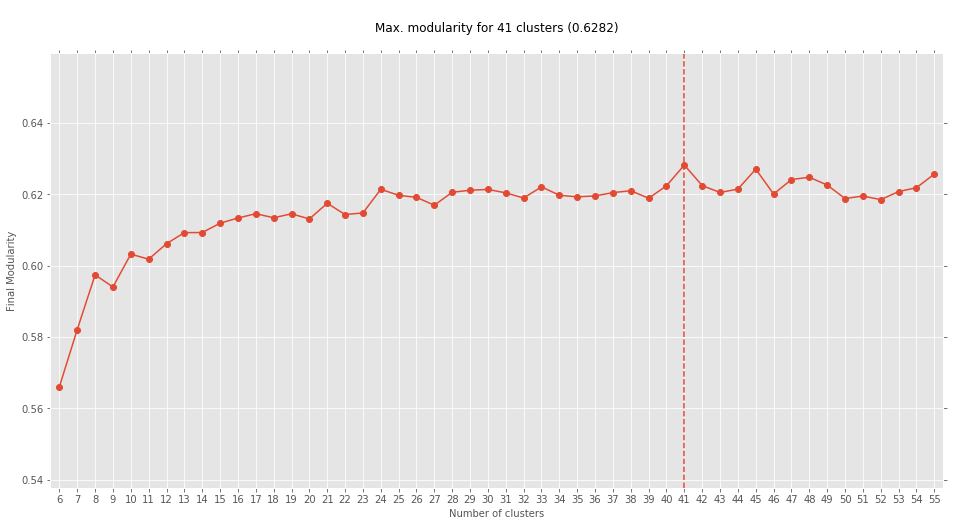

In [0]:
plt.rcParams["figure.figsize"] = (16, 8)
plot_max_modularities(modularities, range(6, 56))

In [0]:
clusters_range = range(6, 56)
model, modularities = best_modularity_partition(np.array(user_product_rating_matrix_train), 
                                                clusters_range, n_rand_init=10)

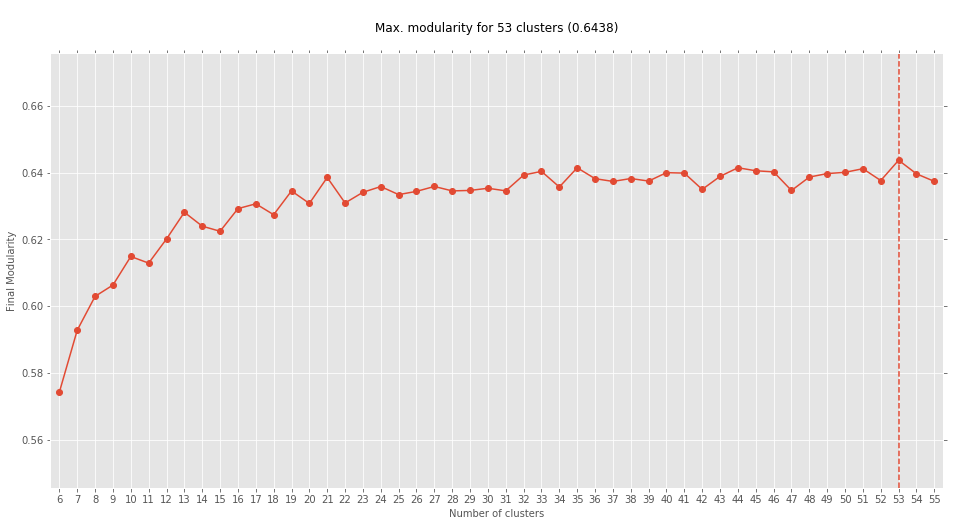

In [0]:
plt.rcParams["figure.figsize"] = (16, 8)
plot_max_modularities(modularities, range(6, 56))

In [0]:
clusters_range = range(3, 31)
model, modularities = best_modularity_partition(user_category_matrix_train, 
                                                clusters_range, n_rand_init=10)

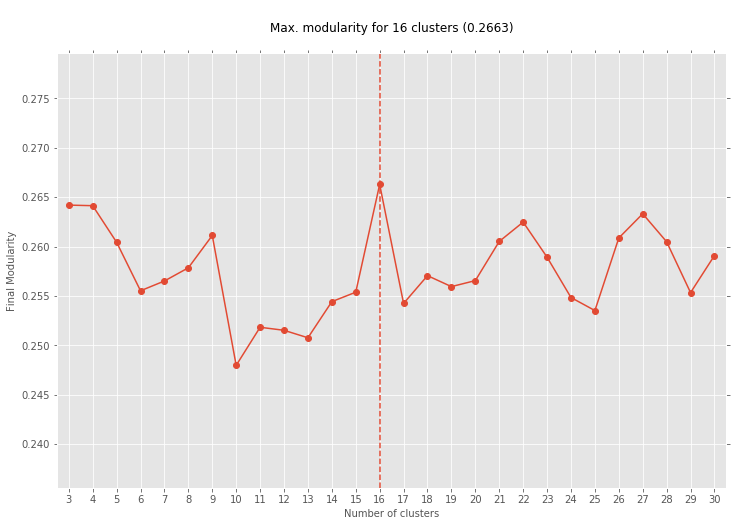

In [0]:
plt.rcParams["figure.figsize"] = (12, 8)
plot_max_modularities(modularities, range(3, 31))

In [0]:
clusters_range = range(3, 31)
model, modularities = best_modularity_partition(np.array(user_category_rating_matrix_train), 
                                                clusters_range, n_rand_init=10)

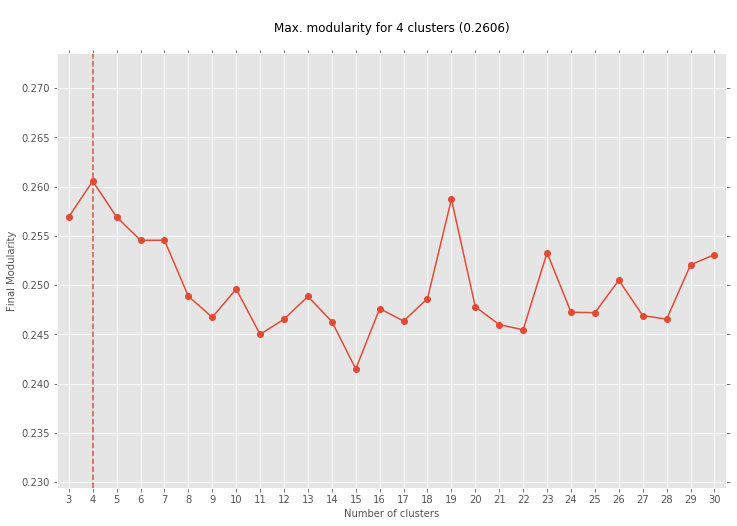

In [0]:
plt.rcParams["figure.figsize"] = (12, 8)
plot_max_modularities(modularities, range(3, 31))

In [0]:
## 24-cluster solution on product
cocluster_user_item = CoclustMod(n_clusters=24, random_state=42)
cocluster_user_item.fit(user_product_matrix_train)
## results
predicted_row_labels = cocluster_user_item.row_labels_
predicted_column_labels = cocluster_user_item.column_labels_

In [0]:
## 4-cluster solution on product category
cocluster_user_cat = CoclustMod(n_clusters=4, random_state=42)
cocluster_user_cat.fit(user_category_matrix_train)
## results
predicted_row_labels2 = cocluster_user_cat.row_labels_
predicted_column_labels2 = cocluster_user_cat.column_labels_

In [0]:
## 21-cluster solution on product ratings
cocluster_user_item_rate = CoclustMod(n_clusters=21, random_state=42)
cocluster_user_item_rate.fit(np.array(user_product_rating_matrix_train))
## results
predicted_row_labels_rate = cocluster_user_item_rate.row_labels_
predicted_column_labels_rate = cocluster_user_item_rate.column_labels_

In [0]:
## 4-cluster solution on product category ratings
cocluster_user_cat_rate = CoclustMod(n_clusters=4, random_state=42)
cocluster_user_cat_rate.fit(np.array(user_category_rating_matrix_train))
## results
predicted_row_labels_rate2 = cocluster_user_cat_rate.row_labels_
predicted_column_labels_rate2 = cocluster_user_cat_rate.column_labels_

In [0]:
def plot_cluster_sizes(row_label, column_label):
  plot_df = pd.concat([
              pd.concat([pd.Series(row_label), pd.Series(['Rows']*len(row_label))], axis=1),
              pd.concat([pd.Series(column_label), pd.Series(['Columns']*len(column_label))], axis=1)],
            axis=0)
  plot_df.columns = ['CoCluster', 'Group']
  ax = seaborn.countplot(x='CoCluster', hue='Group', data=plot_df)
  for txt in ax.patches:
    ax.text(txt.get_x() + txt.get_width()/2, txt.get_height(), '%d' % int(txt.get_height()), 
            fontsize=11, ha='center', va='bottom')
  return

Rows: 906
Row Clusters: 24
Columns: 11078
Column Clusters: 24


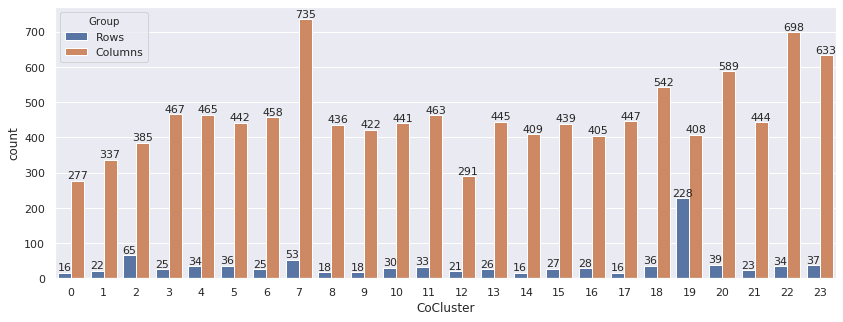

In [0]:
print("Rows: " + str(len(predicted_row_labels)))
print("Row Clusters: " + str(len(np.unique(predicted_row_labels))))
print("Columns: " + str(len(predicted_column_labels)))
print("Column Clusters: " + str(len(np.unique(predicted_column_labels))))
seaborn.set(rc={'figure.figsize':(14.0, 5.0)})
plot_cluster_sizes(predicted_row_labels, predicted_column_labels)

Rows: 906
Row Clusters: 4
Columns: 320
Column Clusters: 4


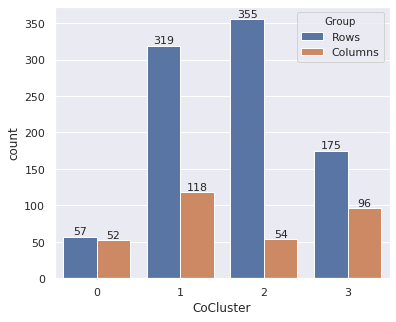

In [0]:
print("Rows: " + str(len(predicted_row_labels2)))
print("Row Clusters: " + str(len(np.unique(predicted_row_labels2))))
print("Columns: " + str(len(predicted_column_labels2)))
print("Column Clusters: " + str(len(np.unique(predicted_column_labels2))))
seaborn.set(rc={'figure.figsize':(6.0, 5.0)})
plot_cluster_sizes(predicted_row_labels2, predicted_column_labels2)

Rows: 906
Row Clusters: 21
Columns: 11078
Column Clusters: 21


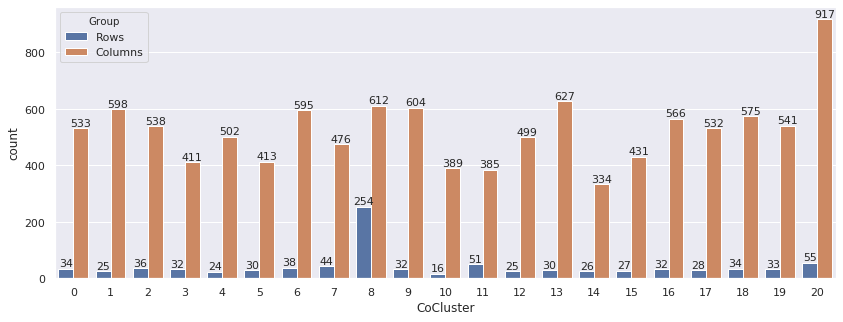

In [0]:
print("Rows: " + str(len(predicted_row_labels_rate)))
print("Row Clusters: " + str(len(np.unique(predicted_row_labels_rate))))
print("Columns: " + str(len(predicted_column_labels_rate)))
print("Column Clusters: " + str(len(np.unique(predicted_column_labels_rate))))
seaborn.set(rc={'figure.figsize':(14.0, 5.0)})
plot_cluster_sizes(predicted_row_labels_rate, predicted_column_labels_rate)

Rows: 906
Row Clusters: 4
Columns: 320
Column Clusters: 4


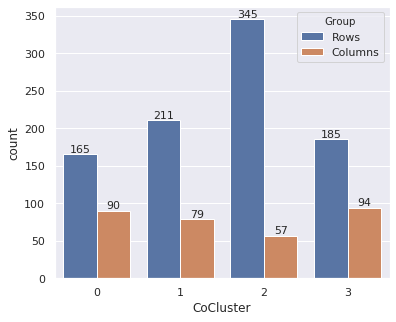

In [0]:
print("Rows: " + str(len(predicted_row_labels_rate2)))
print("Row Clusters: " + str(len(np.unique(predicted_row_labels_rate2))))
print("Columns: " + str(len(predicted_column_labels_rate2)))
print("Column Clusters: " + str(len(np.unique(predicted_column_labels_rate2))))
seaborn.set(rc={'figure.figsize':(6.0, 5.0)})
plot_cluster_sizes(predicted_row_labels_rate2, predicted_column_labels_rate2)

In [0]:
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import consensus_score
biclust_sk = SpectralBiclustering(n_clusters=(20, 8), method="bistochastic", random_state=42)
biclust_sk_user_cat = biclust_sk.fit(user_category_matrix_train)
biclust_sk_user_cat_rate = biclust_sk.fit(user_category_rating_matrix_train)

In [0]:
print(biclust_sk_user_cat.rows_.shape)
print(biclust_sk_user_cat.columns_.shape)
print(biclust_sk_user_cat_rate.rows_.shape)
print(biclust_sk_user_cat_rate.columns_.shape)

(160, 906)
(160, 320)
(160, 906)
(160, 320)


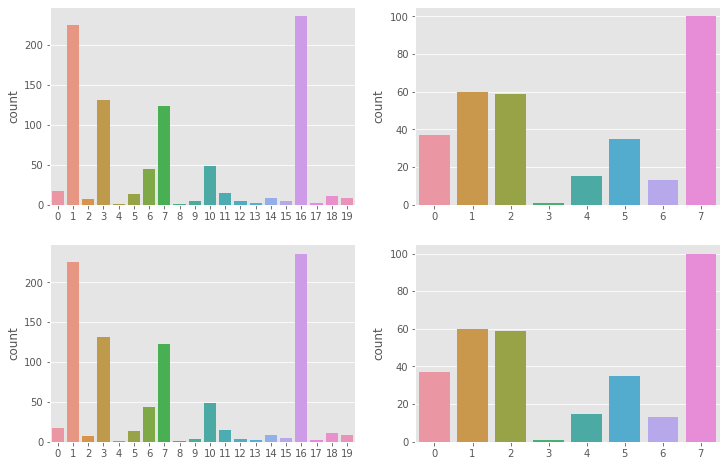

In [0]:
fig, ax = plt.subplots(2,2,figsize=(12, 8))
seaborn.countplot(biclust_sk_user_cat.row_labels_.astype('object'), ax=ax[0][0])
seaborn.countplot(biclust_sk_user_cat.column_labels_.astype('object'), ax=ax[0][1])
seaborn.countplot(biclust_sk_user_cat_rate.row_labels_.astype('object'), ax=ax[1][0])
seaborn.countplot(biclust_sk_user_cat_rate.column_labels_.astype('object'), ax=ax[1][1])

In [0]:
user_product_cocluster_r = pd.concat([user_names_train, 
                                      pd.DataFrame(predicted_row_labels)], axis=1)
user_product_rate_cocluster_r = pd.concat([user_names_train, 
                                           pd.DataFrame(predicted_row_labels_rate)], axis=1)
user_category_cocluster_r = pd.concat([user_names_train, 
                                       pd.DataFrame(predicted_row_labels2)], axis=1)
user_category_rate_cocluster_r = pd.concat([user_names_train, 
                                            pd.DataFrame(predicted_row_labels_rate2)], axis=1)
user_product_cocluster_c = pd.concat([prod_names_train, 
                                      pd.DataFrame(predicted_column_labels)], axis=1)
user_product_rate_cocluster_c = pd.concat([prod_names_train, 
                                           pd.DataFrame(predicted_column_labels_rate)], axis=1)
user_category_cocluster_c = pd.concat([category_names_train, 
                                       pd.DataFrame(predicted_column_labels2)], axis=1)
user_category_rate_cocluster_c = pd.concat([category_names_train, 
                                            pd.DataFrame(predicted_column_labels_rate2)], axis=1)

user_product_cocluster_r.columns = ['UserId', 'Cocluster_user_binary']
user_product_rate_cocluster_r.columns = ['UserId', 'Cocluster_user_rating']
user_category_cocluster_r.columns = ['UserId', 'Cocluster_user_binary']
user_category_rate_cocluster_r.columns = ['UserId', 'Cocluster_user_rating']
user_product_cocluster_c.columns = ['ProductId', 'Cocluster_product_binary']
user_product_rate_cocluster_c.columns = ['ProductId', 'Cocluster_product_rating']
user_category_cocluster_c.columns = ['ProductId_cat', 'Cocluster_category_binary']
user_category_rate_cocluster_c.columns = ['ProductId_cat', 'Cocluster_category_rating']

In [0]:
def oh_vec_cocluster(coclust_df):

  coclust_onehot = OneHotEncoder().fit_transform(coclust_df.iloc[:,1].values.reshape(-1, 1)).toarray()
  coclust_onehot_df = pd.DataFrame(coclust_onehot)

  col_names = []
  for cocluster in range(coclust_onehot_df.shape[1]):
    col_names.append(coclust_df.columns[1] + str(cocluster))
  coclust_onehot_df.columns = col_names

  coclust_onehot_df = pd.concat([coclust_df.iloc[:,0], coclust_onehot_df], axis=1)

  return coclust_onehot_df

user_product_cocluster_r_vec = oh_vec_cocluster(user_product_cocluster_r)
user_product_rate_cocluster_r_vec = oh_vec_cocluster(user_product_rate_cocluster_r)
user_category_cocluster_r_vec = oh_vec_cocluster(user_category_cocluster_r)
user_category_rate_cocluster_r_vec = oh_vec_cocluster(user_category_rate_cocluster_r)
user_product_cocluster_c_vec = oh_vec_cocluster(user_product_cocluster_c)
user_product_rate_cocluster_c_vec = oh_vec_cocluster(user_product_rate_cocluster_c)
user_category_cocluster_c_vec = oh_vec_cocluster(user_category_cocluster_c)
user_category_rate_cocluster_c_vec = oh_vec_cocluster(user_category_rate_cocluster_c)

<b>Multiple Correspondence Analysis:</b>

For modelling hidden factors with a dimension smaller than the number of features (for this case the product IDs in the user-product matrix), principal component analysis (PCA) decomposes the matrix into reduced components of linear weights on the original continuous features, and each component would not be easily interpretable or used to explain the correlated variables within the component; while factor analysis (FA) has assumptions on no multi-collinearity and independence of the model error terms, which might be violated under a sparse and nominal / binary data setting. The ordinary factor analysis may not be suitable for non-continuous data and users would run statistical metrics like Bartlett’s Test and Kaiser-Meyer-Olkin Test to evaluate whether FA should be applied.

For categorical data, multiple correspondence analysis (MCA) models the contingency tables of all classes (transformed into an indicator matrix with column encoded as one class of a particular variable) to extract latent factor scoring with SVD methods. These factor scores, projected in lower dimension by methods like T-SNE (t-distributed stochastic neighbour embeddings), could display proximity of different variables (products in close coordinates may suggest certain relationships or similarities). Benzécri correction was proposed to deal with the underestimation of variance, as defaulted in the MCA library.

To evaluate the MCA results based on the user-product binary indicator matrix, we could plot the principal inertia (varainces explained by each factor), given the maximized variance in the first few dimensions (eigenvalue operations in SVD), it would be observed as a decreasing concave curve. A specified level of proportion of cumulative variance, e.g. 80%, could be retained in 364 factors out of 852 total dimensions for products and 82 factors out of 267 for product categories.


In [0]:
!pip install mca

In [0]:
## Correspndence Analysis for binary data
import mca
mca_user_product_df = mca.MCA(user_product_df)
mca_user_category_df = mca.MCA(user_category_df)

In [0]:
k = 1   ## dimensionality reduction factor
print(mca_user_product_df.fs_r(k).shape) '''factor scores for each sample; 
                                            number of latent factors < number of products'''
print(mca_user_product_df.fs_r(0.8 * k).shape)  '''cumulative variance explained cut-off 
                                                    at specified values < 1'''
print(mca_user_product_df.fs_r(0.5 * k).shape)
print(mca_user_category_df.fs_r(k).shape)
print(mca_user_category_df.fs_r(0.8 * k).shape)
print(mca_user_category_df.fs_r(0.5 * k).shape)

(906, 852)
(906, 364)
(906, 181)
(906, 267)
(906, 82)
(906, 27)


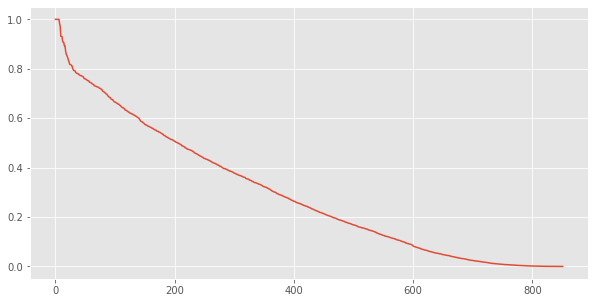

In [0]:
## eigenvalues (principal inertias) of the reduced factors
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(mca_user_product_df.L)

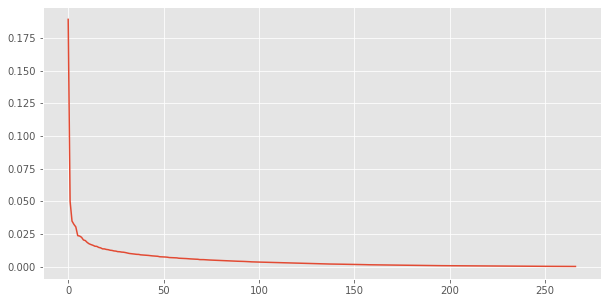

In [0]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(mca_user_category_df.L)

In [0]:
mca_user_product_factor_score = pd.concat([user_names_train, 
                                           pd.DataFrame(mca_user_product_df.fs_r(0.8))], axis=1)
mca_user_category_factor_score = pd.concat([user_names_train, 
                                            pd.DataFrame(mca_user_category_df.fs_r(0.8))], axis=1)
mca_user_product_factor_score.columns = ['UserId'] + ['mca_factor' + str(i) for i in range(1, mca_user_product_factor_score.shape[1])]
mca_user_category_factor_score.columns = ['UserId'] + ['mca_factor' + str(i) for i in range(1, mca_user_category_factor_score.shape[1])]

<b>Matrix Factorization:</b>

Various matrix decomposition algorithms with SVD are proven to be successfully applied in collaborative filtering driven recommender systems. Given the user-item rating matrix (R), the target would be finding the weight matrix (W) and the component matrix (H) in which we can express R = W．H (dot product of the two matrices). Weight matrix corresponds to the user embeddings while component matrix corresponds to the item embeddings of the same number of hidden factors.

To get estimations the weights, we could assign randomized initial values of the latent dimensions by normal distributions, and apply stochastic gradient descent (SGD) to iterate and update the weights minimizing the defined objective cost dunction. Since rating scores were used, loss function could be mean absolute error or mean squred difference, addition of L2 norm regularization terms to the cost function helped balance the overfitting problem. 

Besides SGD matrix factorization, tensorflow provided a module with weighted alternating least square algorithm (WALS) that differentiates the ordinary least square cost function into two parts, to first optimize the matrix W with fixed values of H and then optimize matrix H with fixed values of W in each iteration step. Weighted factors scaled and adapted for the row and column variations of imbalanced frequencies. The regularization terms with respect to the inidividual component of the two matrices could also be weighted with a parameter. The Google Cloud Solution delivered a good tutorial on the WALS model in tensorflow: https://cloud.google.com/solutions/machine-learning/recommendation-system-tensorflow-create-model

A more efficient implementation of Non-negative matrix factorization in sci-kit learn provided alternatives of using multiplicative updates or coordinate descent to support Frobenius norm or Kullback-leibler convergence as the cost function to optimize.


In [0]:
import tensorflow as tf

In [0]:
## SGD-based Matrix Factorization
## extract latent embeddings (dimensions) of users and products applied on the rating matrix
def train_sgd_mf(input_data, product_ref_col, num_user, num_item):
  
  latent_dim = 100
  user = LabelEncoder().fit_transform(input_data['UserId'].values)
  item = LabelEncoder().fit_transform(input_data[product_ref_col].values)
  # Initializing randomized matrices W and H
  user_indices = [x for x in user]
  item_indices = [x for x in item]
  ratings = input_data.mean_score.values

  W = tf.Variable(tf.truncated_normal([num_user, latent_dim]), name="users")
  H = tf.Variable(tf.truncated_normal([latent_dim, num_item]), name="items")
  result = tf.matmul(W, H)

  # training predictions
  result_values = tf.gather(tf.reshape(result, [-1]), 
                            [user_indices[i] * tf.shape(result)[1] + item_indices[i] 
                             for i in range(len(input_data))], 
                             name="learnt_ratings")

  # differences between training predictions & actual observations
  # define regularized cost function
  delta = tf.squared_difference(result_values, ratings, name='training_error_square_diff')
  cost = tf.reduce_sum(delta, name="sum_squared_error")
  regularizer = tf.multiply(tf.add(tf.reduce_sum(tf.square(W)), tf.reduce_sum(tf.square(H))), 
                            tf.constant(0.01, name='lambda'), name="regularized_norm")
  regularized_cost = tf.math.divide(tf.add(cost, regularizer), len(ratings) * 2.0, name="std_error")

  # optimizer for stochastic gradient descent with momentum & learning rate
  lr = tf.constant(0.001, name='learning_rate')
  global_step = tf.Variable(0, trainable=False)
  learning_rate = tf.train.exponential_decay(lr, global_step, 1000, 0.95, staircase=True)
  optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
  training_step = optimizer.minimize(regularized_cost, global_step=global_step)

  sess = tf.Session()
  init = tf.global_variables_initializer()
  sess.run(init)
  for i in range(10001):
      sess.run(training_step)
      if i%100==0:
          print("Step " + str(i) + " Training Loss: %f" % sess.run(cost))
      learnt_W = sess.run(W)
      learnt_H = sess.run(H)

  return learnt_W, learnt_H

In [0]:
learnt_W_p, learnt_H_p = train_sgd_mf(rate_agg_train, 'ProductId', 
                                      user_product_rating_matrix_train.shape[0],
                                      user_product_rating_matrix_train.shape[1])

Step 0 Training Loss: 1774306.250000
Step 100 Training Loss: 1747609.250000
Step 200 Training Loss: 1719157.125000
Step 300 Training Loss: 1691315.125000
Step 400 Training Loss: 1664065.750000
Step 500 Training Loss: 1637392.625000
Step 600 Training Loss: 1611279.375000
Step 700 Training Loss: 1585710.375000
Step 800 Training Loss: 1560671.000000
Step 900 Training Loss: 1536146.625000
Step 1000 Training Loss: 1512135.000000
Step 1100 Training Loss: 1489765.500000
Step 1200 Training Loss: 1467825.000000
Step 1300 Training Loss: 1446302.625000
Step 1400 Training Loss: 1425188.000000
Step 1500 Training Loss: 1404471.000000
Step 1600 Training Loss: 1384142.125000
Step 1700 Training Loss: 1364191.500000
Step 1800 Training Loss: 1344610.250000
Step 1900 Training Loss: 1325389.500000
Step 2000 Training Loss: 1306530.000000
Step 2100 Training Loss: 1288923.625000
Step 2200 Training Loss: 1271620.250000
Step 2300 Training Loss: 1254613.250000
Step 2400 Training Loss: 1237896.000000
Step 2500 Tr

In [0]:
learnt_W_c, learnt_H_c = train_sgd_mf(rate_agg_c_train, 'ProductId_cat', 
                                      user_category_rating_matrix_train.shape[0],
                                      user_category_rating_matrix_train.shape[1])

Step 0 Training Loss: 1168764.375000
Step 100 Training Loss: 1135794.500000
Step 200 Training Loss: 1101544.250000
Step 300 Training Loss: 1068889.750000
Step 400 Training Loss: 1037725.937500
Step 500 Training Loss: 1007956.812500
Step 600 Training Loss: 979494.687500
Step 700 Training Loss: 952258.750000
Step 800 Training Loss: 926175.000000
Step 900 Training Loss: 901175.000000
Step 1000 Training Loss: 877207.875000
Step 1100 Training Loss: 855321.750000
Step 1200 Training Loss: 834258.250000
Step 1300 Training Loss: 813974.187500
Step 1400 Training Loss: 794429.250000
Step 1500 Training Loss: 775586.062500
Step 1600 Training Loss: 757409.687500
Step 1700 Training Loss: 739867.375000
Step 1800 Training Loss: 722928.562500
Step 1900 Training Loss: 706564.375000
Step 2000 Training Loss: 690755.812500
Step 2100 Training Loss: 676215.375000
Step 2200 Training Loss: 662126.000000
Step 2300 Training Loss: 648468.375000
Step 2400 Training Loss: 635224.125000
Step 2500 Training Loss: 622376

In [0]:
## extracted weight matrix size: (num_rows, num_latent_dim)
print(learnt_W_p.shape)
print(learnt_H_p.shape)
print(learnt_W_c.shape)
print(learnt_H_c.shape)

(906, 100)
(100, 11078)
(906, 100)
(100, 320)


In [0]:
learnt_W_p = pd.concat([user_names_train, learnt_W_p], axis=1)
learnt_W_c = pd.concat([user_names_train, learnt_W_c], axis=1)
learnt_H_p = pd.concat([prod_names_train, learnt_H_p.T.reset_index(drop=True)], axis=1)
learnt_H_c = pd.concat([category_names_train, learnt_H_c.T.reset_index(drop=True)], axis=1)
learnt_W_p.columns = ['UserId'] + ['sgd_mf_factor_u' + str(i) for i in range(1, learnt_W_p.shape[1])]
learnt_W_c.columns = ['UserId'] + ['sgd_mf_factor_u' + str(i) for i in range(1, learnt_H_c.shape[1])]
learnt_H_p.columns = ['ProductId'] + ['sgd_mf_factor_p' + str(i) for i in range(1, learnt_H_p.shape[1])]
learnt_H_c.columns = ['ProductId_cat'] + ['sgd_mf_factor_c' + str(i) for i in range(1, learnt_W_c.shape[1])]

In [0]:
from tensorflow.contrib.factorization import WALSModel
from scipy import sparse

In [0]:
## WALS-based Matrix Factorization
def train_wals(input_data, product_ref_col):

  user = LabelEncoder().fit_transform(input_data['UserId'].values)
  item = LabelEncoder().fit_transform(input_data[product_ref_col].values)
  # Initializing randomized matrices W and H
  user_indices = [x for x in user]
  item_indices = [x for x in item]
  ratings = input_data.mean_score.values

  n_users = input_data['UserId'].unique().shape[0]
  n_items = input_data[product_ref_col].unique().shape[0]
  rating_init = np.zeros((n_users, n_items))
  
  input_tensor = tf.SparseTensor(indices=pd.concat([pd.Series(user_indices), 
                                                    pd.Series(item_indices)], axis=1),
                                 values=(ratings).astype(np.float32),
                                 dense_shape=(n_users, n_items))

  wals = WALSModel(n_users, n_items, 100, regularization = 0.01, unobserved_weight=1.0,
                   row_weights = n_users / (n_users + n_items), 
                   col_weights = n_items / (n_users + n_items))
  ## initialized row & column latent factor vectors
  user_factors = wals.row_factors[0]
  item_factors = wals.col_factors[0]
  ## update factor vectors during the training process
  row_update_op = wals.update_row_factors(sp_input=input_tensor)[1]
  col_update_op = wals.update_col_factors(sp_input=input_tensor)[1]

  sess = tf.Session()
  sess.run(wals.initialize_op)
  sess.run(wals.worker_init)
  for i in range(10001):
      sess.run(wals.row_update_prep_gramian_op)
      sess.run(wals.initialize_row_update_op)
      sess.run(row_update_op)
      sess.run(wals.col_update_prep_gramian_op)
      sess.run(wals.initialize_col_update_op)
      sess.run(col_update_op)

  ## extracted trained user (row) and item (column) latent factors
  output_row = user_factors.eval(session=sess)
  output_col = item_factors.eval(session=sess)
  
  return output_row, output_col

In [0]:
wals_p_row, wals_p_col = train_wals(rate_agg_train, 'ProductId')

In [0]:
wals_c_row, wals_c_col = train_wals(rate_agg_c_train, 'ProductId_cat')

In [0]:
print(wals_c_row.shape)
print(wals_c_col.shape)
print(wals_p_row.shape)
print(wals_p_col.shape)

(906, 100)
(320, 100)
(906, 100)
(11078, 100)


In [0]:
wals_p_row = pd.concat([user_names_train, pd.DataFrame(wals_p_row)], axis=1)
wals_c_row = pd.concat([user_names_train, pd.DataFrame(wals_c_row)], axis=1)
wals_p_col = pd.concat([prod_names_train, pd.DataFrame(wals_p_col)], axis=1)
wals_c_col = pd.concat([category_names_train, pd.DataFrame(wals_c_col)], axis=1)
wals_p_row.columns = ['UserId'] + ['wals_mf_factor_u' + str(i) for i in range(1, wals_p_row.shape[1])]
wals_c_row.columns = ['UserId'] + ['wals_mf_factor_u' + str(i) for i in range(1, wals_c_row.shape[1])]
wals_p_col.columns = ['ProductId'] + ['wals_mf_factor_p' + str(i) for i in range(1, wals_p_col.shape[1])]
wals_c_col.columns = ['ProductId_cat'] + ['wals_mf_factor_c' + str(i) for i in range(1, wals_c_col.shape[1])]

In [0]:
from sklearn.decomposition import NMF
nnmf_p = NMF(n_components=100, init='nndsvd', solver='mu', max_iter=1000, random_state=42, verbose=1).fit(user_product_rating_matrix_train)
nnmf_c = NMF(n_components=100, init='nndsvd', solver='mu', max_iter=1000, random_state=42, verbose=1).fit(user_category_rating_matrix_train)

Epoch 10 reached after 1.512 seconds, error: 504.347063
Epoch 20 reached after 2.989 seconds, error: 498.910077
Epoch 30 reached after 4.532 seconds, error: 498.245197
Epoch 40 reached after 6.068 seconds, error: 498.081435
Epoch 50 reached after 7.549 seconds, error: 497.976857
Epoch 60 reached after 8.993 seconds, error: 497.934483
Epoch 10 reached after 0.070 seconds, error: 343.571872
Epoch 20 reached after 0.127 seconds, error: 324.871728
Epoch 30 reached after 0.181 seconds, error: 320.814043
Epoch 40 reached after 0.237 seconds, error: 319.079702
Epoch 50 reached after 0.300 seconds, error: 318.175258
Epoch 60 reached after 0.362 seconds, error: 317.382399
Epoch 70 reached after 0.419 seconds, error: 316.768389
Epoch 80 reached after 0.477 seconds, error: 316.404148
Epoch 90 reached after 0.539 seconds, error: 316.148239
Epoch 100 reached after 0.601 seconds, error: 315.985706
Epoch 110 reached after 0.661 seconds, error: 315.877032
Epoch 120 reached after 0.721 seconds, error: 

In [0]:
nnmf_W_p = nnmf_p.transform(user_product_rating_matrix_train)
nnmf_W_c = nnmf_c.transform(user_category_rating_matrix_train)

Epoch 10 reached after 0.453 seconds, error: 496.057754
Epoch 20 reached after 0.672 seconds, error: 495.989121
Epoch 30 reached after 0.880 seconds, error: 495.979010
Epoch 10 reached after 0.019 seconds, error: 284.060021
Epoch 20 reached after 0.034 seconds, error: 283.414820
Epoch 30 reached after 0.050 seconds, error: 283.277735
Epoch 40 reached after 0.067 seconds, error: 283.224956
Epoch 50 reached after 0.085 seconds, error: 283.199289


In [0]:
print(nnmf_W_p.shape)
print(nnmf_p.components_.shape)
print(nnmf_W_c.shape)
print(nnmf_c.components_.shape)

(906, 100)
(100, 11078)
(906, 100)
(100, 320)


In [0]:
nnmf_W_user_p = pd.concat([user_names_train, nnmf_W_user_p], axis=1)
nnmf_W_user_c = pd.concat([user_names_train, nnmf_W_user_c], axis=1)
nnmf_W_p = pd.concat([prod_names_train, nnmf_W_p.T.reset_index(drop=True)], axis=1)
nnmf_W_c = pd.concat([category_names_train, nnmf_W_c.T.reset_index(drop=True)], axis=1)
nnmf_W_user_p.columns = ['UserId'] + ['nmf_factor_u' + str(i) for i in range(1, nnmf_W_user_p.shape[1])]
nnmf_W_user_c.columns = ['UserId'] + ['nmf_factor_u' + str(i) for i in range(1,nnmf_W_user_c.shape[1])]
nnmf_W_p.columns = ['ProductId'] + ['nmf_factor_p' + str(i) for i in range(1, nnmf_W_p.shape[1])]
nnmf_W_c.columns = ['ProductId_cat'] + ['nmf_factor_c' + str(i) for i in range(1, nnmf_W_c.shape[1])]

<b>Doc2Vec:</b>

Regarding to the contents-derived features, the TF-IDF matrix could be extremely sparse and suffering from the problem of dimensionality in the later analysis. To get the latent features, Word2Vec is a shallow neural network model that projects the tokens onto a high dimensional vector space through the word embedding layer. Additionally, the token similarity could be investigated by providing a token or between a pair of tokens. While two types of word2vec model were introduced in the gensim word2vec algorithms: continuous bag of words (CBOW) and skip-gram. The fundamental difference of the two is that CBOW used the former and latter words as inputs (contexts) to predict the current word, while skip-gram would take the opposite way to infer the neighnouring words by the current word. The practice below had implemented the CBOW algorithm as by default.

It was suggested to use 100 to 1000 features for representation and differentiation of each word, for this exercise I specified 400 dimensions. The window parameter referred to the maximum range of neighbouring words included with respect to the current word as an input (skip-gram) or output (CBOW). For long texts, window can be set higher over 100, now it was assigned to be 10 considering the relatively short lengths of fine food reviews. Only tokens having more than 10 frequency counts were retained, aligning to the minimum degree of freedom (10) in the previous TF-IDF scheme transformation.

<b>Distributed Memory of paragraph vector</b><br>
<img src="pic/PVDM.png" /><br>
<b>Distributed Bag of Words</b><br>
<img src="pic/DBOW.png" />

In [0]:
from gensim.models import doc2vec

In [0]:
## list of tokenized documents
encoder = []
for y in range(len(trunc_df_train['tokenized'])):
  token_ = []
  for m in range(len(trunc_df_train['tokenized'][y].split(' '))):
    token_.append(trunc_df_train['tokenized'][y].split(' ')[m])
  encoder.append(token_)

In [0]:
## ## create review text embeddings
## fit a Doc2Vec model
documents = [doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(encoder)]
d2v = doc2vec.Doc2Vec(documents, vector_size=400, window=10, min_count=2, seed=1, workers=8)
d2v.train(documents, total_examples=len(documents), epochs=100)

In [0]:
## extract doc2vec dimensions
doc_v = []
doc_label = []
for doc in range(len(d2v.docvecs)):
    doc_v.append(d2v.docvecs[doc])
    doc_label.append('Review' + str(doc+1))
doc_vector = pd.DataFrame(doc_v)
v = []
for u in range(400):
    v.append('doc2vec' + str(u+1))
v = np.array(v)
doc_vector.columns = v

In [0]:
## aggregate text embedding vectors
doc_embed_df = pd.concat([trunc_df_train[['tokenized', 'UserId', 'ProductId', 'ProductId_cat']], 
                          doc_vector], axis=1)
doc_embed_user_product = doc_embed_df.groupby(by=['UserId', 'ProductId']).agg(['mean','max','min'])
doc_embed_user_category = doc_embed_df.groupby(by=['UserId', 'ProductId_cat']).agg(['mean','max','min'])
doc_embed_user_product = doc_embed_user_product.reset_index()
doc_embed_user_category = doc_embed_user_category.reset_index()
doc_embed_user_product.columns = ['UserId', 'ProductId'] + [' '.join(doc_embed_user_product.columns[i]) for i in range(2, doc_embed_user_product.shape[1])]
doc_embed_user_category.columns = ['UserId', 'ProductId_cat'] + [' '.join(doc_embed_user_category.columns[i]) for i in range(2, doc_embed_user_category.shape[1])]       

<b>Deep Learing Classifier & Regressor for rating score prediction:</b>

There are mainly 3 types of data structure for making recommendations based on ranking items in the basket for each user: 1) pointwise; 2) pairwise; 3) listwise. Pointwise approach focuses on the target of continuous or ordinal rating score and present as a regression problem (or ordinal logistic regression). Pairwise does transformation for N items we got N - 1 binary vectors, and then predicts by classification algorithms like RankSVM whether the item <i>k</i> obtains a higher rank than another item <i>m</i> among N items in the dataset. While like a correlation matrix, the diagonal vector is always 1 (same item). Listwise approach defines loss function for the scores of the list of all items to generate optimized rankings, like discounted cumulative gain instead of mean suqared errors, as against the pointwise approach which predicts the score independently on the user-item pairs.

Google's research scholar introduced in 2010 a combined regression and ranking system to adopt a weighted trade-off between the pointwise regression loss and the pairwaise logit loss, and run stochastic gradient descent for optimization on this combined loss (<i>Sculley, D. (2010, July). Combined regression and ranking. In Proceedings of the 16th ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 979-988). retrievable from: http://www.eecs.tufts.edu/~dsculley/papers/combined-ranking-and-regression.pdf </i>). 

Due to the highly imbalanced class sizes of positive against non-positive samples, purely regressing on the rating scores by least mean error might lead to skewed predictions. I tried to implement the pointwise approach using deep neural network in tensorflow with a stepwise design comprised of two stages, first classifying the polarity from the positive-class against non-positive-class probabilities on the user-item pairs with SMOTE resampling the inputs, and then adding this probability for training the second regression model on the final numeric scores. Lastly, sorting the predicted scores, we could get the rankings for each user and validate with the items they purchased in the testing set. 

Evaluation metrics for recommender system differ from general regression or classification problem, as it usually involves rankings. A common metric is the mean average precision (MAP), which iterates the ranked items given by the algorithm and the actual ranked order, returns the maximum precision until the first, second, third, etc. true positive was found. MAP is obtained by thaking average of the maximum precision on each position, and taking the mean across the user-item queries. However for this dataset, as having over 11,000 different products and only 906 customers to deal with, and many customers averagely bought fewer than 10 products in the testing period, sparsity is a curse for obtaining a good precision. From analytics perspective on this sparse dataset, examining the recall score would be the first indicator assessing the conversion rate whether customers really purchased the products in the recommended list. Intersection-over-Union score is another metric for object identification. When applied on recommendation system, it measures the extent of matching predicted item set and bought item set. F-Beta score is a trade-off between precision and recall, while setting Beta > 1 would weigh recall heavier. Here I presented a F-4 score.


In [0]:
## imbalanced class for positive ratings, neutral ratings and negative ratings
rate_agg_train['positive'] = rate_agg_train['mean_score'].apply(lambda x: 0 if x < 3 else 1)
rate_agg_test['positive'] = rate_agg_test['mean_score'].apply(lambda x: 0 if x < 3 else 1)
rate_agg_c_train['positive'] = rate_agg_c_train['mean_score'].apply(lambda x: 0 if x < 3 else 1)
rate_agg_c_test['positive'] = rate_agg_c_test['mean_score'].apply(lambda x: 0 if x < 3 else 1)

In [0]:
## Combined features from Assoc_Rules, Co-Cluster, MCA, SGD / WALS / NNMF, Doc2Vec to do Rating Score predictions
## Learning to Rank:
###   1) Neural Network based two-stage classification & regression 
###   2) NDCG optimized Boosting

def combined_features(user_item_ratings_df, product_ref_col, 
                      coclust_features_row_bin, coclust_features_col_bin, 
                      coclust_features_row_rat, coclust_features_col_rat,
                      ar_features, mca_features, doc2vec_embeddings, 
                      sgd_mf_factors_user, sgd_mf_factors_item, 
                      wals_mf_factors_user, wals_mf_factors_item,
                      nnmf_factors_user, nnmf_factors_item):
  
  user_item_ratings_df = user_item_ratings_df.merge(coclust_features_row_bin, 
                                                    how='left', on=['UserId'])
  user_item_ratings_df = user_item_ratings_df.merge(coclust_features_col_bin, 
                                                    how='left', on=[product_ref_col])
  user_item_ratings_df = user_item_ratings_df.merge(coclust_features_row_rat, 
                                                    how='left', on=['UserId'])
  user_item_ratings_df = user_item_ratings_df.merge(coclust_features_col_rat, 
                                                    how='left', on=[product_ref_col])
  user_item_ratings_df = user_item_ratings_df.merge(ar_features, 
                                                    how='left', on=['UserId', product_ref_col])
  user_item_ratings_df = user_item_ratings_df.merge(mca_features, 
                                                    how='left', on=['UserId'])
  user_item_ratings_df = user_item_ratings_df.merge(doc2vec_embeddings, 
                                                    how='left', on=['UserId', product_ref_col])
  user_item_ratings_df = user_item_ratings_df.merge(sgd_mf_factors_user, 
                                                    how='left', on=['UserId'])
  user_item_ratings_df = user_item_ratings_df.merge(sgd_mf_factors_item, 
                                                    how='left', on=[product_ref_col])
  user_item_ratings_df = user_item_ratings_df.merge(wals_mf_factors_user, 
                                                    how='left', on=['UserId'])
  user_item_ratings_df = user_item_ratings_df.merge(wals_mf_factors_item, 
                                                    how='left', on=[product_ref_col])
  user_item_ratings_df = user_item_ratings_df.merge(nnmf_factors_user, 
                                                    how='left', on=['UserId'])
  user_item_ratings_df = user_item_ratings_df.merge(nnmf_factors_item, 
                                                    how='left', on=[product_ref_col])

  return user_item_ratings_df

In [0]:
user_product_ratings_df = combined_features(rate_agg_train, 'ProductId', 
                                            user_product_cocluster_r_vec, user_product_cocluster_c_vec, 
                                            user_product_rate_cocluster_r_vec, 
                                            user_product_rate_cocluster_c_vec,
                                            assoc_rule_p_df, mca_user_product_factor_score, 
                                            doc_embed_user_product, 
                                            learnt_W_p, learnt_H_p, 
                                            wals_p_row, wals_p_col,
                                            nnmf_W_user_p, nnmf_W_p)

In [0]:
user_category_ratings_df = combined_features(rate_agg_c_train, 'ProductId_cat', 
                                            user_category_cocluster_r_vec, user_category_cocluster_c_vec, 
                                            user_category_rate_cocluster_r_vec, 
                                            user_category_rate_cocluster_c_vec,
                                            assoc_rule_c_df, mca_user_category_factor_score, 
                                            doc_embed_user_category, 
                                            learnt_W_c, learnt_H_c, 
                                            wals_c_row, wals_c_col,
                                            nnmf_W_user_c, nnmf_W_c)

In [0]:
print(user_product_ratings_df.shape)
print(user_category_ratings_df.shape)

(22707, 2263)
(15145, 1907)


In [0]:
## i) one-hot encoded co-clusters
## ii) standardize scaling features
## iii) fill NA values of association rule features with 0

def preprocessing(df, start_col, df_scaler=None):
  df = df.fillna(0)
  
  if df_scaler==None:
    df_scaler = StandardScaler().fit(df.iloc[:, start_col:])

  scaled_df = pd.DataFrame(df_scaler.transform(df.iloc[:, start_col:]))
  scaled_df.columns = ['sc' + z for z in df.columns[start_col:]]

  processed_df = pd.concat([df.iloc[:,0:start_col], scaled_df], axis=1)

  return df_scaler, processed_df

In [0]:
scaler_user_product_ratings_df, user_product_ratings_df_sc = preprocessing(
    user_product_ratings_df, 
    4 + user_product_cocluster_r_vec.shape[1] - 1 + 
        user_product_cocluster_c_vec.shape[1] - 1 + 
        user_product_rate_cocluster_r_vec.shape[1] - 1 + 
        user_product_rate_cocluster_c_vec.shape[1] - 1)
scaler_user_category_ratings_df, user_category_ratings_df_sc = preprocessing(
    user_category_ratings_df, 
    4 + user_category_cocluster_r_vec.shape[1] - 1 + 
        user_category_cocluster_c_vec.shape[1] - 1 + 
        user_category_rate_cocluster_r_vec.shape[1] - 1 + 
        user_category_rate_cocluster_c_vec.shape[1] - 1)

In [0]:
## train-test_split
from sklearn.model_selection import train_test_split

user_product_ratings_df_sc_X_train, user_product_ratings_df_sc_X_test, \
user_product_ratings_df_sc_y_train, user_product_ratings_df_sc_y_test \
= train_test_split(
    user_product_ratings_df_sc.iloc[:,4:], 
    user_product_ratings_df_sc.iloc[:,2:4], 
    stratify=user_product_ratings_df_sc.iloc[:,3],
    test_size=0.2, random_state=42)

user_category_ratings_df_sc_X_train, user_category_ratings_df_sc_X_test, \
user_category_ratings_df_sc_y_train, user_category_ratings_df_sc_y_test \
= train_test_split(
    user_category_ratings_df_sc.iloc[:,4:], 
    user_category_ratings_df_sc.iloc[:,2:4], 
    stratify=user_category_ratings_df_sc.iloc[:,3],
    test_size=0.2, random_state=42)

In [0]:
from imblearn.over_sampling import SMOTE

class get_ratings:
  def __init__(self, train_X, train_y, test_X, test_y, random_num):
      self.train_X = train_X.reset_index(drop=True)
      self.train_y = train_y.reset_index(drop=True)
      self.test_X = test_X.reset_index(drop=True)
      self.test_y = test_y.reset_index(drop=True)
      self.random_num = random_num
      self.balanced_sample = None
      self.X_res = None
      self.y_res = None
      self.y_res_sc = None
      self.model_r = None
      self.model_c = None
      
  def re_sample(self):
      rs = SMOTE(sampling_strategy = 'not majority', random_state = self.random_num)
      ## mean score vector
      y_res_sc, y_res = rs.fit_resample(self.train_y.iloc[:,0].values.reshape(-1,1), 
                                        self.train_y.iloc[:,1])
      ## feature set vectors
      X_res, y_res = rs.fit_resample(self.train_X, self.train_y.iloc[:,1])
      return X_res, y_res, y_res_sc

  def ratings_regression_and_classification_model(self):
    features = tf.placeholder(tf.float32, shape=(None, self.train_X.shape[1]))
    target = tf.placeholder(tf.float32, shape=(None, ))

    feature_shape = features.shape[1]

    for model in range(2):

      input_layer = tf.keras.layers.Input(shape=(feature_shape, ))
      layer_1 = tf.keras.layers.Dense(feature_shape * 2, activation='relu', name='layer1')(input_layer)
      dropout_1 = tf.keras.layers.Dropout(0.3, name='dropout1')(layer_1)
      layer_2 = tf.keras.layers.Dense(1000, activation='relu', name='layer2')(dropout_1)
      dropout_2 = tf.keras.layers.Dropout(0.2, name='dropout2')(layer_2)
      layer_3 = tf.keras.layers.Dense(500, activation='relu', name='layer3')(dropout_2)
      dropout_3 = tf.keras.layers.Dropout(0.1, name='dropout3')(layer_3)
      layer_4 = tf.keras.layers.Dense(100, activation='relu', name='layer4')(dropout_3)
      dropout_4 = tf.keras.layers.Dropout(0.05, name='dropout4')(layer_4)
      layer_5 = tf.keras.layers.Dense(20, activation='relu', name='layer5')(dropout_4)
      dropout_5 = tf.keras.layers.Dropout(0.01, name='dropout5')(layer_5)

      feature_shape += 1

      if model==0:
        output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(dropout_5)
        keras_model_classification = tf.keras.models.Model(input_layer, output_layer)
        keras_model_classification.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                                          optimizer=tf.keras.optimizers.Adam(learning_rate = 0.000001),
                                          metrics=[tf.keras.metrics.BinaryAccuracy(), 
                                                   tf.keras.metrics.AUC()])
      else:
        output_layer = tf.keras.layers.Dense(1, activation='linear', name='outputs')(dropout_5)
        keras_model_regression = tf.keras.models.Model(input_layer, output_layer)
        keras_model_regression.compile(loss=tf.keras.losses.MeanAbsoluteError(), 
                                      optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001))

    return keras_model_classification, keras_model_regression

  def identifying_positive(self, model_c, balanced_sample=None):
    if balanced_sample!=None:
      X, y, y_res_sc = self.re_sample()
      self.balanced_sample = balanced_sample
      self.X_res = X
      self.y_res = y
      self.y_res_sc = y_res_sc
    else:
      X, y = self.train_X, self.train_y.iloc[:,1]

    model_c.fit(X, y, batch_size=20, epochs=20, validation_data=[self.test_X, self.test_y.iloc[:,1]])

    identifier_train = model_c.predict(X)
    identifier_train = pd.DataFrame(identifier_train, columns=['positive_prob'])
    identifier_test = model_c.predict(self.test_X)
    identifier_test = pd.DataFrame(identifier_test, columns=['positive_prob'])

    self.model_c = model_c
    return X, y, y_res_sc, identifier_train, identifier_test, model_c
  
  def reshaping_regressor_dataframe(self, identifier_for_positive_train, identifier_for_positive_test):
    if self.balanced_sample != None:
      X_train = pd.DataFrame(self.X_res, columns=self.train_X.columns)
    else:
      X_train = self.train_X

    reshape_train_X = pd.concat([X_train, identifier_for_positive_train], axis=1)
    reshape_test_X = pd.concat([X_test, identifier_for_positive_test], axis=1)
    return reshape_train_X, reshape_test_X

  def fit(self, model_r, reshaped_train_X, reshape_test_X):
    if self.balanced_sample != None:
      y = pd.DataFrame(self.y_res_sc)
    else:
      y = self.train_y.iloc[:,0]

    model_r.fit(reshaped_train_X, y, batch_size=20, epochs=20, 
                validation_data=[reshape_test_X, self.test_y.iloc[:,0]], shuffle=True)

    pred = model_r.predict(reshape_test_X)
    self.model_r = model_r
    return model_r, pred

  def get_predicted_ratings_rankings(self, unseen_data, user_item_labels, 
                                     filter_by_positive_prob_threshold=None, 
                                     trained_classifier=None, trained_regressor=None):
    if trained_classifier!=None:
      pred_pos = trained_classifier.predict(unseen_data)
    else:
      pred_pos = self.model_c.predict(unseen_data)
    pred_pos = pd.DataFrame(pred_pos, columns=['positive_prob'])
    reshaped = pd.concat([unseen_data, pred_pos], axis=1)

    ## fast screening and retaining items with high probability of predicted positive-rating-class
    if filter_by_positive_prob_threshold!=None:
      reshaped = reshaped[reshaped['positive_prob'] >= filter_by_positive_prob_threshold]

    if trained_regressor!=None:
      final_pred = trained_regressor.predict(reshaped)
    else:
      final_pred = self.model_r.predict(reshaped)
    final_pred = pd.DataFrame(final_pred, columns=['pred_ratings'])
    final_pred = pd.concat([user_item_labels, final_pred], axis=1)
    return final_pred

In [0]:
get_ratings_p = get_ratings(user_product_ratings_df_sc_X_train, user_product_ratings_df_sc_y_train,
                            user_product_ratings_df_sc_X_test, user_product_ratings_df_sc_y_test, 42)

model_classification_p, model_regression_p = get_ratings_p.ratings_regression_and_classification_model()
res_tr_X_p, res_tr_y_p, res_tr_y_psc, prob_pos_tr_p, prob_pos_ts_p, model_classification_p \
  = get_ratings_p.identifying_positive(model_classification_p, balanced_sample=1)
reshape_tr_X_p, reshape_ts_X_p = get_ratings_p.reshaping_regressor_dataframe(prob_pos_tr_p, prob_pos_ts_p)
model_regression_p, _ = get_ratings_p.fit(model_regression_p, reshape_tr_X_p, reshape_ts_X_p)

Train on 32398 samples, validate on 4542 samples
Epoch 1/20
32398/32398 [==============================] - 13s 401us/sample - loss: 0.6794 - binary_accuracy: 0.5706 - auc_4: 0.6147 - val_loss: 0.5168 - val_binary_accuracy: 0.8910 - val_auc_4: 0.7136
Epoch 2/20
32398/32398 [==============================] - 12s 357us/sample - loss: 0.5765 - binary_accuracy: 0.7290 - auc_4: 0.8155 - val_loss: 0.4221 - val_binary_accuracy: 0.8738 - val_auc_4: 0.8226
Epoch 3/20
32398/32398 [==============================] - 12s 355us/sample - loss: 0.4540 - binary_accuracy: 0.8221 - auc_4: 0.8994 - val_loss: 0.3570 - val_binary_accuracy: 0.8688 - val_auc_4: 0.8598
Epoch 4/20
32398/32398 [==============================] - 12s 356us/sample - loss: 0.3623 - binary_accuracy: 0.8630 - auc_4: 0.9339 - val_loss: 0.3022 - val_binary_accuracy: 0.8840 - val_auc_4: 0.8713
Epoch 5/20
32398/32398 [==============================] - 12s 362us/sample - loss: 0.3038 - binary_accuracy: 0.8879 - auc_4: 0.9512 - val_loss: 0.2

In [0]:
get_ratings_c = get_ratings(user_category_ratings_df_sc_X_train, user_category_ratings_df_sc_y_train,
                            user_category_ratings_df_sc_X_test, user_category_ratings_df_sc_y_test, 42)

model_classification_c, model_regression_c = get_ratings_c.ratings_regression_and_classification_model()
res_tr_X_c, res_tr_y_c, res_tr_y_csc, prob_pos_tr_c, prob_pos_ts_c, model_classification_c \
  = get_ratings_c.identifying_positive(model_classification_c, balanced_sample=1)
reshape_tr_X_c, reshape_ts_X_c = get_ratings_c.reshaping_regressor_dataframe(prob_pos_tr_c, prob_pos_ts_c)
model_regression_c, _ = get_ratings_c.fit(model_regression_c, reshape_tr_X_c, reshape_ts_X_c)

Train on 21692 samples, validate on 3029 samples
Epoch 1/20
21692/21692 [==============================] - 9s 412us/sample - loss: 0.6892 - binary_accuracy: 0.5412 - auc_6: 0.5657 - val_loss: 0.5292 - val_binary_accuracy: 0.8904 - val_auc_6: 0.6339
Epoch 2/20
21692/21692 [==============================] - 7s 339us/sample - loss: 0.6344 - binary_accuracy: 0.6335 - auc_6: 0.7464 - val_loss: 0.4744 - val_binary_accuracy: 0.8891 - val_auc_6: 0.7238
Epoch 3/20
21692/21692 [==============================] - 7s 341us/sample - loss: 0.5738 - binary_accuracy: 0.7219 - auc_6: 0.8245 - val_loss: 0.4360 - val_binary_accuracy: 0.8772 - val_auc_6: 0.7854
Epoch 4/20
21692/21692 [==============================] - 7s 335us/sample - loss: 0.4996 - binary_accuracy: 0.7890 - auc_6: 0.8786 - val_loss: 0.3796 - val_binary_accuracy: 0.8795 - val_auc_6: 0.8233
Epoch 5/20
21692/21692 [==============================] - 7s 340us/sample - loss: 0.4340 - binary_accuracy: 0.8236 - auc_6: 0.9080 - val_loss: 0.3588 -

In [0]:
## make predictions via two stages: get regression ratings for category (filtering) --> ranking top categories --> get regression ratings for products --> ranking top products
## map the learnt factors and embeddings (features extracted for training user-item pairs) to testing user-item pairs
def gather_top_k_category(top_n=None, model_type=None, 
                          classifier=None, regressor=None, ranker=None):
  gather_top_k_category = []
  for user in list_u:
    query = combinations_c[combinations_c['UserId']==user].iloc[:,:2]
    user_category_features_test = combined_features(query, 'ProductId_cat', 
                                      user_category_cocluster_r_vec, user_category_cocluster_c_vec, 
                                      user_category_rate_cocluster_r_vec, 
                                      user_category_rate_cocluster_c_vec,
                                      assoc_rule_c_df, mca_user_category_factor_score, 
                                      doc_embed_user_category, 
                                      learnt_W_c, learnt_H_c, 
                                      wals_c_row, wals_c_col,
                                      nnmf_W_user_c, nnmf_W_c)
    _, user_category_features_test_sc = preprocessing(
                user_category_features_test, 
                2 + user_category_cocluster_r_vec.shape[1] - 1 + 
                    user_category_cocluster_c_vec.shape[1] - 1 + 
                    user_category_rate_cocluster_r_vec.shape[1] - 1 + 
                    user_category_rate_cocluster_c_vec.shape[1] - 1,
                df_scaler = scaler_user_category_ratings_df)
    
    if model_type=='combined':
      pred_pos_c = pd.DataFrame(classifier.predict(user_category_features_test_sc.iloc[:,2:]), 
                                columns=['positive_prob'])
      reshaped = pd.concat([user_category_features_test_sc.iloc[:,2:], pred_pos_c], axis=1)
      final_pred = pd.DataFrame(regressor.predict(reshaped), columns=['pred_ratings_cat'])
      final_pred = pd.concat([user_category_features_test_sc.iloc[:,0:2], final_pred], axis=1)

    elif model_type=='booster':
      final_pred = pd.DataFrame(ranker.predict(user_category_features_test_sc.iloc[:,2:]), 
                                columns=['pred_ratings_cat'])
      final_pred = pd.concat([user_category_features_test_sc.iloc[:,0:2], final_pred], axis=1)

    if top_n == None:
      top_k_category = final_pred.sort_values(by='pred_ratings_cat', 
                                              ascending=False).reset_index(drop=True)
    else:
      top_k_category = final_pred.sort_values(by='pred_ratings_cat', 
                                              ascending=False).reset_index(drop=True).iloc[0:top_n]

    gather_top_k_category.append(top_k_category)

  return gather_top_k_category

In [0]:
## full set
gather_category = gather_top_k_category(model_type='combined', 
                                        classifier=model_classification_c, 
                                        regressor=model_regression_c)
## top-ranked set
gather_top_category = gather_top_k_category(top_n=100, model_type='combined', 
                                            classifier=model_classification_c, 
                                            regressor=model_regression_c)

In [0]:
combinations_p['ProductId_cat'] = combinations_p['ProductId'].apply(lambda x: str(x)[0:5])

In [0]:
## make top N ranked recommendations
def gather_top_k_product(batch_start, batch_end, top_n=None, positive_screening=None,
                         model_type=None, classifier=None, regressor=None, ranker=None):
  gather_top_k_product = []
  gather_category_set = gather_category if positive_screening==None else gather_top_category

  for q in range(len(gather_category_set[batch_start:batch_end])):
    user = gather_category_set[q]['UserId'][0]
    category = gather_category_set[q]['ProductId_cat'].values
    query = combinations_p[(combinations_p['UserId']==user) & 
                           (combinations_p['ProductId_cat'].isin(category))].iloc[:,:2]
    user_product_features_test = combined_features(query, 'ProductId',
                                      user_product_cocluster_r_vec, user_product_cocluster_c_vec, 
                                      user_product_rate_cocluster_r_vec, 
                                      user_product_rate_cocluster_c_vec,
                                      assoc_rule_p_df, mca_user_product_factor_score, 
                                      doc_embed_user_product, 
                                      learnt_W_p, learnt_H_p, 
                                      wals_p_row, wals_p_col,
                                      nnmf_W_user_p, nnmf_W_p)
    _, user_product_features_test_sc = preprocessing(
                user_product_features_test, 
                2 + user_product_cocluster_r_vec.shape[1] - 1 + 
                    user_product_cocluster_c_vec.shape[1] - 1 + 
                    user_product_rate_cocluster_r_vec.shape[1] - 1 + 
                    user_product_rate_cocluster_c_vec.shape[1] - 1,
                df_scaler = scaler_user_product_ratings_df)
    
    if model_type=='combined':
      pred_pos_p = pd.DataFrame(classifier.predict(user_product_features_test_sc.iloc[:,2:]), 
                                columns=['positive_prob'])
      reshaped = pd.concat([user_product_features_test_sc.iloc[:,2:], pred_pos_p], axis=1)
      final_pred = pd.DataFrame(regressor.predict(reshaped), columns=['pred_ratings'])
      final_pred = pd.concat([user_product_features_test_sc.iloc[:,0:2], final_pred], axis=1)

    elif model_type=='booster':
      final_pred = pd.DataFrame(ranker.predict(user_product_features_test_sc.iloc[:,2:]), 
                                columns=['pred_ratings'])
      final_pred = pd.concat([user_product_features_test_sc.iloc[:,0:2], final_pred], axis=1)

    if top_n==None:
      top_k_product = final_pred.sort_values(by='pred_ratings', 
                                             ascending=False).reset_index(drop=True)
    else:
      top_k_product = final_pred.sort_values(by='pred_ratings', 
                                             ascending=False).reset_index(drop=True).iloc[0:top_n]

    gather_top_k_product.append(top_k_product)

  return gather_top_k_product

In [0]:
gather_top_k_product_1 = gather_top_k_product(batch_start=0, batch_end=100, 
                                              top_n=100, model_type='combined', 
                                              classifier=model_classification_p, 
                                              regressor=model_regression_p)

In [0]:
gather_top_k_product_2 = gather_top_k_product(batch_start=100, batch_end=200, 
                                              top_n=100, model_type='combined', 
                                              classifier=model_classification_p, 
                                              regressor=model_regression_p)

In [0]:
gather_top_k_product_3 = gather_top_k_product(batch_start=200, batch_end=300, 
                                              top_n=100, model_type='combined', 
                                              classifier=model_classification_p, 
                                              regressor=model_regression_p)

In [0]:
gather_top_k_product_4 = gather_top_k_product(batch_start=300, batch_end=400, 
                                              top_n=100, model_type='combined', 
                                              classifier=model_classification_p, 
                                              regressor=model_regression_p)

In [0]:
gather_top_k_product_5 = gather_top_k_product(batch_start=400, batch_end=500, 
                                              top_n=100, model_type='combined', 
                                              classifier=model_classification_p, 
                                              regressor=model_regression_p)

In [0]:
gather_top_k_product_6 = gather_top_k_product(batch_start=500, batch_end=600, 
                                              top_n=100, model_type='combined', 
                                              classifier=model_classification_p, 
                                              regressor=model_regression_p)

In [0]:
gather_top_k_product_7 = gather_top_k_product(batch_start=600, batch_end=700, 
                                              top_n=100, model_type='combined', 
                                              classifier=model_classification_p, 
                                              regressor=model_regression_p)

In [0]:
gather_top_k_product_8 = gather_top_k_product(batch_start=700, batch_end=800, 
                                              top_n=100, model_type='combined', 
                                              classifier=model_classification_p, 
                                              regressor=model_regression_p)

In [0]:
gather_top_k_product_9 = gather_top_k_product(batch_start=800, batch_end=len(gather_top_category), 
                                              top_n=100, model_type='combined', 
                                              classifier=model_classification_p, 
                                              regressor=model_regression_p)

In [0]:
def validate_recommendation_results_by_top_N(recommended_set_df, actual_set_df, 
                                             beta, col, pred_col, top_N=None):
  precision_list = []
  recall_list = []
  IoU_list = []
  fbeta_list = []
  mean_absolute_error = []

  for q in range(len(recommended_set_df)):
    queried_user = recommended_set_df[q]['UserId'][0]
    actual = actual_set_df[actual_set_df['UserId']==queried_user]
    ranked_actual_set_df = actual.sort_values(by='mean_score', ascending=False).reset_index(drop=True)

    if len(actual) > 0:
      num_TP = len([v for v in ranked_actual_set_df[col].values 
                      if v in recommended_set_df[q][col].values])
      num_Pred = len(recommended_set_df[q])
      num_Prod = len(actual)
      precision = num_TP / num_Pred
      recall = num_TP / num_Prod
      IoU_score = num_TP / (num_Pred + num_Prod - num_TP)
      fbeta_score = 0 if (precision==0) & (recall==0) 
                      else (1 + beta**2) * (precision * recall) / (precision * beta**2 + recall)
      
      precision_list.append(precision)
      recall_list.append(recall)
      IoU_list.append(IoU_score)
      fbeta_list.append(fbeta_score)

      mae = []
      for r in range(len(recommended_set_df[q])):
        if recommended_set_df[q][col][r] in ranked_actual_set_df[col].values:
          p = recommended_set_df[q][col][r]
          y_hat = recommended_set_df[q][pred_col][r]
          y = ranked_actual_set_df[ranked_actual_set_df[col]==p]['mean_score'].values
          mae.append(abs(y_hat - y))
      mean_absolute_error.append(np.mean(mae))
      
  return precision_list, recall_list, IoU_list, fbeta_list, mean_absolute_error

In [0]:
p1, r1, iou1, fbeta1, mae1 = validate_recommendation_results_by_top_N(
    gather_top_k_product_1, rate_agg_test, 4, 'ProductId', 'pred_ratings')
p2, r2, iou2, fbeta2, mae2 = validate_recommendation_results_by_top_N(
    gather_top_k_product_2, rate_agg_test, 4, 'ProductId', 'pred_ratings')
p3, r3, iou3, fbeta3, mae3 = validate_recommendation_results_by_top_N(
    gather_top_k_product_3, rate_agg_test, 4, 'ProductId', 'pred_ratings')
p4, r4, iou4, fbeta4, mae4 = validate_recommendation_results_by_top_N(
    gather_top_k_product_4, rate_agg_test, 4, 'ProductId', 'pred_ratings')
p5, r5, iou5, fbeta5, mae5 = validate_recommendation_results_by_top_N(
    gather_top_k_product_5, rate_agg_test, 4, 'ProductId', 'pred_ratings')
p6, r6, iou6, fbeta6, mae6 = validate_recommendation_results_by_top_N(
    gather_top_k_product_6, rate_agg_test, 4, 'ProductId', 'pred_ratings')
p7, r7, iou7, fbeta7, mae7 = validate_recommendation_results_by_top_N(
    gather_top_k_product_7, rate_agg_test, 4, 'ProductId', 'pred_ratings')
p8, r8, iou8, fbeta8, mae8 = validate_recommendation_results_by_top_N(
    gather_top_k_product_8, rate_agg_test, 4, 'ProductId', 'pred_ratings')
p9, r9, iou9, fbeta9, mae9 = validate_recommendation_results_by_top_N(
    gather_top_k_product_9, rate_agg_test, 4, 'ProductId', 'pred_ratings')

In [0]:
all_p_top_N = p1+p2+p3+p4+p5+p6+p7+p8+p9
all_r_top_N = r1+r2+r3+r4+r5+r6+r7+r8+r9
all_fbeta_top_N = fbeta1+fbeta2+fbeta3+fbeta4+fbeta5+fbeta6+fbeta7+fbeta8+fbeta9
all_iou_top_N = iou1+iou2+iou3+iou4+iou5+iou6+iou7+iou8+iou9
all_mae_top_N = mae1+mae2+mae3+mae4+mae5+mae6+mae7+mae8+mae9

In [0]:
p_c, r_c, iou_c, fbeta_c, mae_c = validate_recommendation_results_by_top_N(
    gather_top_category, rate_agg_c_test, 4, 'ProductId_cat', 'pred_ratings_cat')

In [0]:
precision_recall = [(value1, value2) for (value1, value2) in zip(
                                            [v for v in p_c if v > 0], [v for v in r_c if v > 0])]
count_p_r_c = [precision_recall.count(precision_recall[a]) for a in range(len(precision_recall))]

<b>Results from combined neural classification & regression:</b>

Generating the recommendation lists of top 100 products for each customer, I got precision, recall, intersection-over-union scores from comparing the recommended item set and actual bought item set, and mean absolute error from regression of ratings. For unique product IDs, 14.56% of customers made at least 1 purchase on the products recommended by the model. Same experiment using the truncated 5-digit product ID (category) resulted in an increase of this figure to over 73%. From the distribution plot of recall rate, most lied between 0.2 to 0.5 and a portion of users had recall rate reached 1.0 which meant the recommended list covered all the products the user purchased. As expected, the precision was distributed in ranges below 0.10, while a few recommendations got 0.2 to 0.3 precision and intersection-over-union score. 

The trained recommendation system had better performance on the product category groups, which might be more useful in mining for the styles of fine food products a target customer unattempted but potentially interested, rather than a single product. To position accuarate single product recommendation, K-nearest-neighbours algorithm would be an alternate solution, the shortcoming is the training speed of k-NN increased greatly with the number of products and users.

In [0]:
print('Number of customers in testing set making at least 1 purchase from recommended product ID = ' + 
      str(len([v for v in all_r_top_N if v > 0])) + ' (' + 
      '%.2f' % (len([v for v in all_r_top_N if v > 0]*100) / len(all_r_top_N)) +'%)')

Number of customers in testing set making at least 1 purchase from recommended product ID = 99 (14.56%)


In [0]:
print(
  'Number of customers in testing set making at least 1 purchase from recommended product category = ' + 
  str(len([v for v in r_c if v > 0])) + ' (' + 
  '%.2f' % (len([v for v in r_c if v > 0]*100) / len(r_c)) +'%)')

Number of customers in testing set making at least 1 purchase from recommended product category = 602 (73.24%)


[Text(0, 0.5, 'recall'), Text(0.5, 0, 'precision')]

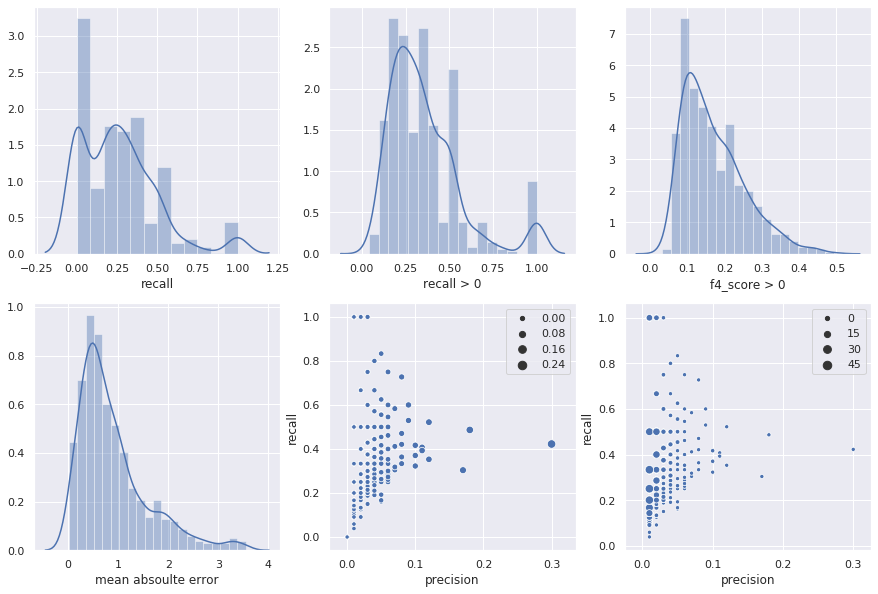

In [0]:
seaborn.set(rc={'figure.figsize':(15.0, 10.0)})
fig, ax = plt.subplots(nrows=2, ncols=3)
seaborn.distplot(r_c, ax=ax[0,0])
seaborn.distplot([v for v in r_c if v > 0], ax=ax[0,1])
seaborn.distplot([v for v in fbeta_c if v > 0], ax=ax[0,2])
seaborn.distplot(mae_c, ax=ax[1,0])
seaborn.scatterplot(x=p_c, y=r_c, size=iou_c, ax=ax[1,1])
seaborn.scatterplot(x=[v for v in p_c if v > 0], y=[v for v in r_c if v > 0], 
                    size=count_p_r_c, ax=ax[1,2])
ax[0,0].set(xlabel='recall')
ax[0,1].set(xlabel='recall > 0')
ax[0,2].set(xlabel='f4_score > 0')
ax[1,0].set(xlabel='mean absoulte error')
ax[1,1].set(xlabel='precision', ylabel='recall')
ax[1,2].set(xlabel='precision', ylabel='recall')

In [0]:
seaborn.set(rc={'figure.figsize':(10.0, 10.0)})
fig, ax = plt.subplots(nrows=2, ncols=2)
seaborn.distplot([v for v in all_r_top_N if v > 0], ax=ax[0,0])
seaborn.distplot([v for v in all_fbeta_top_N if v > 0], ax=ax[0,1])
seaborn.distplot(all_mae_top_N, ax=ax[1,0])
seaborn.scatterplot(x=all_p_top_N, y=all_r_top_N, size=all_iou_top_N, ax=ax[1,1])
ax[0,0].set(xlabel='recall > 0')
ax[0,1].set(xlabel='f4_score')
ax[1,0].set(xlabel='mean absoulte error')
ax[1,1].set(xlabel='precision', ylabel='recall')

<img src="pic/prod_id.PNG" width="450" height="400"/>

<b>NDCG based CatBoost and GradientBoost ranking:</b>

A number of ranking algorithms optimized the cost function with respect to the normalized discounted cumulative gain (NDCG) metric. The relevancy is calculated for each grouped ID (typically analogous to a query in the web search problem, or in this example the user ID) generating the rated items in descending order within the group, applying the quotient between the i-th item's ranking label and its postion or log-position, and summing over all items. The ratio of predicted relevancy to actual relevancy defines NDCG. A normalizing parameter would be added to the formula for the weighted values across all groups. For training the ranker with CatBoost, data rows of the same group should be stacked together for inputting into the model API.

Reference: https://catboost.ai/docs/references/ndcg.html <br>
<img src="https://yastatic.net/doccenter/images/tech2.yandex.com/en/catboost/doc/freeze/BHpu6pYHtKfX_qyxrejsuO0hJtI.svg"/><br>
<img src="https://yastatic.net/doccenter/images/tech2.yandex.com/en/catboost/doc/freeze/04zVkBaIUdgPP5ZCiG6HF0Kjx8E.svg"/><br>
<i><b>**(predicted DCG / target DCG): <br></b></i><img src="https://yastatic.net/doccenter/images/tech2.yandex.com/en/catboost/doc/freeze/2X7AwSmVzF8Cv9nu0eNoOjXPYF4.svg"/><br>
<img src="https://yastatic.net/doccenter/images/tech2.yandex.com/en/catboost/doc/freeze/tgxclGhRLahO3iFY8SqpT4OuSLI.svg"/><br>

In LightGBM implementation of gradient boosting ranker, there are two main objective functions: Lambda-rank and cross-entropy-NDCG loss. The former was developed based on the prestigious Microsoft's Lambda-Rank algorithm (<i>reference: <a href="https://papers.nips.cc/paper/2971-learning-to-rank-with-nonsmooth-cost-functions.pdf">https://papers.nips.cc/paper/2971-learning-to-rank-with-nonsmooth-cost-functions.pdf</a></i>), while the later one was defined in a research paper published last year (<i>reference: <a href="https://arxiv.org/abs/1911.09798">https://arxiv.org/abs/1911.09798</a></i>), and it would be added in lightgbm 2.3.2 version. 

In CatBoost, there are a variety of loss functions and metrics usable for optimization, YetiRank presented on Yahoo's learning to rank challenge (<i>reference: <a href="http://proceedings.mlr.press/v14/gulin11a/gulin11a.pdf">http://proceedings.mlr.press/v14/gulin11a/gulin11a.pdf</a></i>), offered an activation-like function to output PFound value given the target falls in the range 0 to 1, and NDCG value given the target lies outside the range 0 to 1. PFound is another metric calculated as the linear summation of each of the i-th item's ranking label and the weightings assigned to that position.

Reference: https://catboost.ai/docs/references/pfound.html <br>
<img src="https://yastatic.net/doccenter/images/tech2.yandex.com/en/catboost/doc/freeze/RuwBMlTXWu9OzCzSDf5aQVWUnmk.svg"/><br>
<img src="https://yastatic.net/doccenter/images/tech2.yandex.com/en/catboost/doc/freeze/ABvvNSSfmd94-5yDHysIqeQ-FfM.svg"/><br>
<img src="https://yastatic.net/doccenter/images/tech2.yandex.com/en/catboost/doc/freeze/Ygg4PCdp07ENuv1x5vC1T-sXCbc.svg"/><br>

The results from the two boosting rankers trained on the same dataset on the fine food product category got 71.2% (LightGBM Lambda-Rank) and 67.5% (CatBoost YetiRank) respectively successful predictions on at least 1 correct purchase that the customer had made during the testing period, which were slightly lower than the two-stage stepwise combined neural classification and regression (73.2%). YetiRank's result was observed to have a slightly higher density (larger proportion) of 1.0 recall rate among the those non-zero accuracy predictions. The F4 scores, precision, and intersection-over-union score were pretty similar.

In [0]:
!pip install catboost
!pip install lightgbm --upgrade --no-deps

In [0]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from catboost import CatBoost
from catboost import Pool

class rank_by_boostings:
  def __init__(self, df):
    self.df = df
    self.train_X = None
    self.train_y = None
    self.test_X = None
    self.test_y = None
  
  def process_split(self):
    df = self.df
    user_idx = pd.DataFrame(LabelEncoder().fit_transform(df.iloc[:,0]), columns=[df.columns[0]])
    item_idx = pd.DataFrame(LabelEncoder().fit_transform(df.iloc[:,1]), columns=[df.columns[1]])
    target_label = df.iloc[:,2].apply(lambda x: int(x))
    df = pd.concat([user_idx, item_idx, target_label, df.iloc[:,3:]], axis=1)

    tr_X, ts_X, tr_y, ts_y = train_test_split(df.iloc[:,np.r_[0:2, 4:df.shape[1]]],
                                              df.iloc[:,2:4],
                                              stratify=df.iloc[:,3],
                                              test_size=0.2, random_state=42)
    self.train_X = tr_X
    self.train_y = tr_y
    self.test_X = ts_X
    self.test_y = ts_y
    return

  def boosting_model(self):
    lambda_ranker = lgb.LGBMRanker(boosting_type='gbdt', objective='lambdarank',
                                  num_leaves=100, max_depth=10, 
                                  learning_rate=0.0001, n_estimators=1000,
                                  n_jobs=4, random_state=42)
    yeti_ranker = CatBoost({'loss_function':'YetiRank', 'eval_metric':'NDCG',
                            'learning_rate': 0.0001, 'iterations': 1000, 'depth': 10, 
                            'use_best_model':True, 'random_seed': 42})
    return lambda_ranker, yeti_ranker
  
  def fitting_lambdarank(self, ranker):
    self.process_split()
    grp_train = self.train_X.groupby(['UserId']).agg({'UserId':['count']}).values.flatten().tolist()
    grp_test = self.test_X.groupby(['UserId']).agg({'UserId':['count']}).values.flatten().tolist()

    ranker.fit(self.train_X.iloc[:,2:], self.train_y.iloc[:,0], 
               group = grp_train,
               eval_set = [(self.test_X.iloc[:,2:], self.test_y.iloc[:,0])],
               eval_group = [grp_test ], 
               eval_metric = ['ncdg'],
               verbose = 20, early_stopping_rounds = 60)
    return ranker
  
  def fitting_yetirank(self, ranker):
    self.process_split()

    sort_tr_X = self.train_X.sort_values(by=['UserId'])
    sort_ts_X = self.test_X.sort_values(by=['UserId'])
    sort_tr_y = self.train_y.reindex(sort_tr_X.index)
    sort_ts_y = self.test_y.reindex(sort_ts_X.index)

    grp_train = sort_tr_X['UserId']
    grp_test = sort_ts_X['UserId']

    ranker.fit(Pool(data = sort_tr_X.iloc[:,2:], 
                    label = sort_tr_y.iloc[:,0], 
                    group_id = grp_train),
               eval_set = Pool(data = sort_ts_X.iloc[:,2:], 
                               label = sort_ts_y.iloc[:,0], 
                               group_id = grp_test), 
               plot=True, verbose = 20, early_stopping_rounds = 60)
    return ranker

In [0]:
product_rank = rank_by_boostings(user_product_ratings_df_sc)
lambda_ranker_p, yeti_ranker_p = product_rank.boosting_model()
lambda_ranker_p = product_rank.fitting_lambdarank(lambda_ranker_p)
yeti_ranker_p = product_rank.fitting_yetirank(yeti_ranker_p)

Training until validation scores don't improve for 60 rounds
[20]	valid_0's ndcg@1: 0.931309
[40]	valid_0's ndcg@1: 0.929677
[60]	valid_0's ndcg@1: 0.937325
[80]	valid_0's ndcg@1: 0.936158
[100]	valid_0's ndcg@1: 0.935417
[120]	valid_0's ndcg@1: 0.935896
Early stopping, best iteration is:
[60]	valid_0's ndcg@1: 0.937325


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9674863	best: 0.9674863 (0)	total: 2.63s	remaining: 43m 52s
20:	test: 0.9810800	best: 0.9810800 (20)	total: 55s	remaining: 42m 45s
40:	test: 0.9825874	best: 0.9825874 (40)	total: 1m 47s	remaining: 41m 54s
60:	test: 0.9824948	best: 0.9826132 (43)	total: 2m 40s	remaining: 41m 2s
80:	test: 0.9822496	best: 0.9826132 (43)	total: 3m 32s	remaining: 40m 9s
100:	test: 0.9822382	best: 0.9826132 (43)	total: 4m 24s	remaining: 39m 16s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9826131939
bestIteration = 43

Shrink model to first 44 iterations.


In [0]:
category_rank = rank_by_boostings(user_category_ratings_df_sc)
lambda_ranker_c, yeti_ranker_c = category_rank.boosting_model()
lambda_ranker_c = category_rank.fitting_lambdarank(lambda_ranker_c)
yeti_ranker_c = category_rank.fitting_yetirank(yeti_ranker_c)

Training until validation scores don't improve for 60 rounds
[20]	valid_0's ndcg@1: 0.857253
[40]	valid_0's ndcg@1: 0.853962
[60]	valid_0's ndcg@1: 0.85502
Early stopping, best iteration is:
[3]	valid_0's ndcg@1: 0.864719


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9694835	best: 0.9694835 (0)	total: 2.18s	remaining: 36m 22s
20:	test: 0.9749987	best: 0.9752602 (15)	total: 44.8s	remaining: 34m 46s
40:	test: 0.9765406	best: 0.9767448 (30)	total: 1m 27s	remaining: 33m 56s
60:	test: 0.9758787	best: 0.9767448 (30)	total: 2m 9s	remaining: 33m 12s
80:	test: 0.9763201	best: 0.9769048 (65)	total: 2m 51s	remaining: 32m 27s
100:	test: 0.9766316	best: 0.9769865 (81)	total: 3m 34s	remaining: 31m 46s
120:	test: 0.9766314	best: 0.9770888 (118)	total: 4m 16s	remaining: 31m 4s
140:	test: 0.9771128	best: 0.9773746 (137)	total: 4m 59s	remaining: 30m 23s
160:	test: 0.9769924	best: 0.9773746 (137)	total: 5m 41s	remaining: 29m 41s
180:	test: 0.9761903	best: 0.9773746 (137)	total: 6m 24s	remaining: 28m 59s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9773746284
bestIteration = 137

Shrink model to first 138 iterations.


In [0]:
gather_rank_category_lgb = gather_top_k_category(top_n=100, model_type='booster', ranker=lambda_ranker_c)
gather_rank_category_cb = gather_top_k_category(top_n=100, model_type='booster', ranker=yeti_ranker_c)

In [0]:
p_c1, r_c1, iou_c1, fbeta_c1, _ = validate_recommendation_results_by_top_N(
    gather_rank_category_lgb, rate_agg_c_test, 4, 'ProductId_cat', 'pred_ratings_cat')

In [0]:
p_c2, r_c2, iou_c2, fbeta_c2, _ = validate_recommendation_results_by_top_N(
    gather_rank_category_cb, rate_agg_c_test, 4, 'ProductId_cat', 'pred_ratings_cat')

In [0]:
precision_recall_r1 = [(value1, value2) for (value1, value2) in zip(
                                          [v for v in p_c1 if v > 0], [v for v in r_c1 if v > 0])]
count_p_r_c1 = [precision_recall_r1.count(precision_recall_r1[a]) 
                      for a in range(len(precision_recall_r1))]
precision_recall_r2 = [(value1, value2) for (value1, value2) in zip(
                                          [v for v in p_c2 if v > 0], [v for v in r_c2 if v > 0])]
count_p_r_c2 = [precision_recall_r2.count(precision_recall_r2[a]) 
                      for a in range(len(precision_recall_r2))]

In [0]:
print(
  'Number of customers in testing set making at least 1 purchase from recommended product category \n' + 
  '(Lambda Ranker from gradient boosting)  = ' +
  str(len([v for v in r_c1 if v > 0])) + ' (' + 
  '%.2f' % (len([v for v in r_c1 if v > 0]*100) / len(r_c1)) +'%)')

Number of customers in testing set making at least 1 purchase from recommended product category 
(Lambda Ranker from gradient boosting)  = 585 (71.17%)


In [0]:
print(
  'Number of customers in testing set making at least 1 purchase from recommended product category \n' + 
  '(Yeti Ranker from categorical boosting)  = ' + 
  str(len([v for v in r_c2 if v > 0])) + ' (' + 
  '%.2f' % (len([v for v in r_c2 if v > 0]*100) / len(r_c2)) +'%)')

Number of customers in testing set making at least 1 purchase from recommended product category 
(Yeti Ranker from categorical boosting)  = 555 (67.52%)


[Text(0, 0.5, 'recall'), Text(0.5, 0, 'precision')]

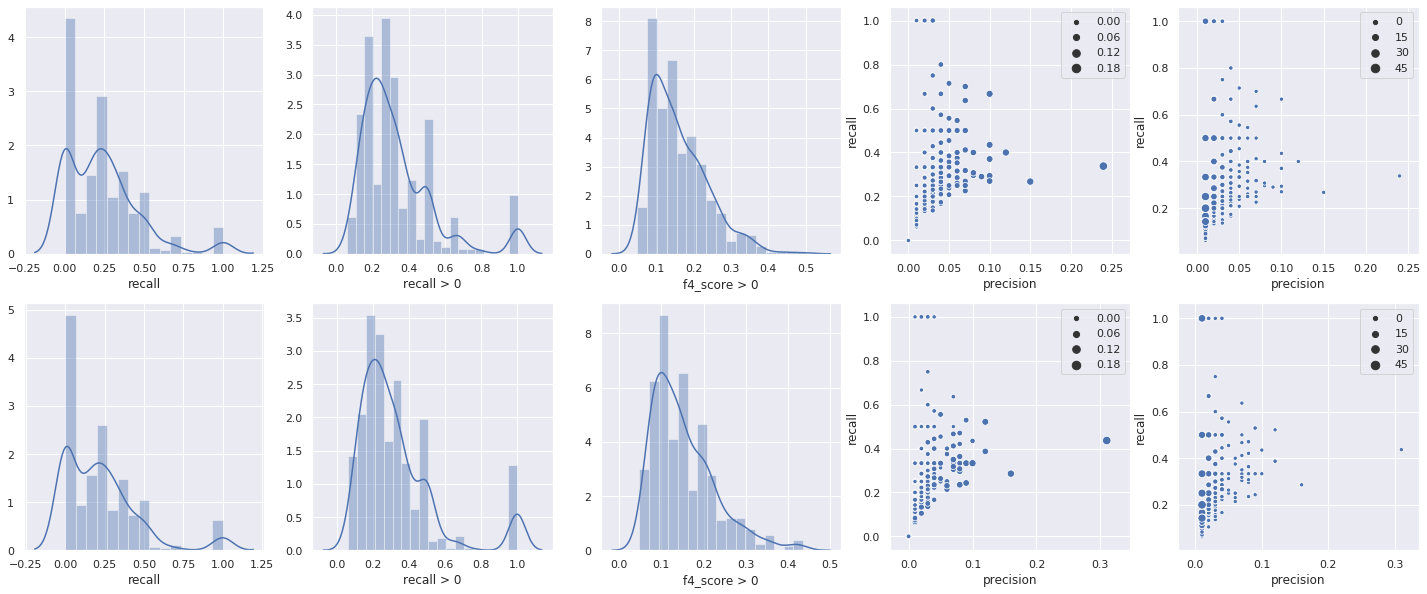

In [0]:
seaborn.set(rc={'figure.figsize':(25.0, 10.0)})
fig, ax = plt.subplots(nrows=2, ncols=5)
seaborn.distplot(r_c1, ax=ax[0,0])
seaborn.distplot([v for v in r_c1 if v > 0], ax=ax[0,1])
seaborn.distplot([v for v in fbeta_c1 if v > 0], ax=ax[0,2])
seaborn.scatterplot(x=p_c1, y=r_c1, size=iou_c, ax=ax[0,3])
seaborn.scatterplot(x=[v for v in p_c1 if v > 0], y=[v for v in r_c1 if v > 0], 
                    size=count_p_r_c1, ax=ax[0,4])
seaborn.distplot(r_c2, ax=ax[1,0])
seaborn.distplot([v for v in r_c2 if v > 0], ax=ax[1,1])
seaborn.distplot([v for v in fbeta_c2 if v > 0], ax=ax[1,2])
seaborn.scatterplot(x=p_c2, y=r_c2, size=iou_c, ax=ax[1,3])
seaborn.scatterplot(x=[v for v in p_c2 if v > 0], y=[v for v in r_c2 if v > 0], 
                    size=count_p_r_c2, ax=ax[1,4])
ax[0,0].set(xlabel='recall')
ax[0,1].set(xlabel='recall > 0')
ax[0,2].set(xlabel='f4_score > 0')
ax[0,3].set(xlabel='precision', ylabel='recall')
ax[0,4].set(xlabel='precision', ylabel='recall')
ax[1,0].set(xlabel='recall')
ax[1,1].set(xlabel='recall > 0')
ax[1,2].set(xlabel='f4_score > 0')
ax[1,3].set(xlabel='precision', ylabel='recall')
ax[1,4].set(xlabel='precision', ylabel='recall')